# **Hack IMDb Rating**

## **Introduction**

Welcome to the Movie Data Analysis Project! This notebook is designed to take you through a comprehensive journey of exploring, analyzing, and understanding the intricate world of movies. Our primary goal is to uncover the factors that influence a movie's success, focusing on aspects such as revenue generation and IMDB ratings.

This notebook is structured to guide you through each step of the process, from data loading and cleaning to in-depth analysis. So, let's dive in and explore the fascinating world of movies through the lens of data science!



## **Research Questions**

1. *What factors contribute to a movie's success, and how do they interplay?*
   - Language and its role in reaching a wider audience
   - Impact of film duration
   - The influence of release timing on ratings
   - How movie genres have evolved over time
   - The correlation between box office success and ratings
   - Geographical patterns in movie ratings 
   

2. *How does diversity and representation influence movie ratings?*
   - Gender diversity within film casts
   - The effect of ethnic diversity on a film's reception

3. *What impact do actors have on a film's rating?*
   - The role of actor types and their influence
   - Effects of actor collaborations on film ratings

4. *Does the portrayal of characters (protagonists) affect ratings?*

5. *Is there a link between real-world events and a movie's success?*
   - Analysis of movie plots in relation to real-world events
   - Comparative study of event-based movies against other genres
   - Exploration of propaganda films and their ratings impact

6. *Can we develop a predictive model for movie ratings?*
   - Utilizing identified key parameters for prediction
   - Implementing sentiment analysis of movie reviews and comments

## **Additional Dataset**

To enrich our analysis, we will add the IMDb ratings dataset.

By addressing these questions with  analytical methods, we aim to offer a comprehensive understanding of the factors influencing IMDb ratings.


In [1]:
#imports
import os
import ast
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from ipywidgets import interact, interactive, fixed, interact_manual
from itertools import combinations
import ipywidgets as widgets
from ipywidgets import IntSlider
from scipy.spatial.distance import cosine
from SPARQLWrapper import SPARQLWrapper, JSON


sns.set_style("whitegrid")
sns.set_context("paper")
sns.set_palette("Set2")
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

---

# **Data Pipeline**


## **Dataset Overview**

### **CMU Movie Summary Corpus**

We begin by analysing data from the CMU Movie Summary Corpus. This collection includes several files:

- *character.metadata.csv:* Contains metadata information about movie characters.
- *movie.metadata.tsv:* Provides movie metadata such as title, genre, and release year.
- *name.cluster.txt:* Offers information related to name clustering.
- *plot_summaries.txt:* Contains summaries of movie plots.
- *tvtropes.cluster.txt:* Includes data on TV Tropes clustering.

### **IMDb Rating Dataset**

Our analysis integrates the IMDb rating dataset taken from [IMDb Datasets](https://datasets.imdbws.com). This dataset comprises two CSV files:

- *rating_id.csv:* Contains IMDb rating data.
- *name_id.csv:* Includes additional information about the movies (name, type, ...).

### **Events Dataset**

Supplementary data, generated by ChatGPT, is included in the analysis. This dataset captures the most significant events from 1820 to 2014 and is created using the code found in `generate_events.py`.

### **Oscar Dataset**

This dataset is a collection of data from The Academy Awards Database, containing the winners and nominees of the Oscars from 1927 to 2023. it is taken from [kaggle Oscars Dataset](https://www.kaggle.com/datasets/unanimad/the-oscar-award) 


#### **1. Loading CMU Data**

We define the `cmu_data_folder` constant to store the path to the CMU Movie Summary Corpus data folder. We then load the data from the different files into pandas dataframes.

In [2]:
cmu_data_folder = 'data/CMU_DATA/'

We define the `movie_metadata_df` dataframe, which contains information about the movies, such as title, box office revenue, movie runtime, genre, and release year.

In [3]:
#read tsv file and add headers
movie_metadata_df = pd.read_csv(cmu_data_folder + 'movie.metadata.tsv', sep='\t', header=None, 
                names=['wiki_movie_id', 
                        'freebase_movie_id', 
                        'movie_name', 
                        'movie_release_date', 
                        'movie_box_office_revenue', 
                        'movie_runtime', 
                        'movie_languages', 
                        'movie_countries', 
                        'movie_genres'])

#changing the values of outliers
movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Zero Tolerance', 'movie_runtime'] = 88
movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Hunting Season', 'movie_release_date'] = '2010-12-02'

#add realase_year
movie_metadata_df['movie_release_year'] = movie_metadata_df['movie_release_date'].str[:4].astype(float)

print("Size of the movie_metadata_df:", movie_metadata_df.shape)
movie_metadata_df.sample(5)

Size of the movie_metadata_df: (81741, 10)


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year
37629,1598127,/m/05fhhb,Rooster Cogburn,1975-10-17,NaN,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/0hfjk"":...",1975.0
9465,24014971,/m/07k7p2t,Three Live Ghosts,1929-09-15,NaN,NaN,{},{},"{""/m/05p553"": ""Comedy film""}",1929.0
3617,10638975,/m/02qky4c,Prem Pujari,1970,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/082gq"": ""War film""}",1970.0
72013,6738041,/m/0glhwy,Private School,1983-07-29,NaN,87.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0gsy3b"": ""...",1983.0
53004,19303744,/m/04ldp41,Uncle Tom's Uncle,1926-05-30,NaN,20.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1926.0


We define the `plot_summaries_df` dataframe, which contains summaries of movie plots.

In [4]:
#loading the plot summaries dataset and add headers
plot_summaries_df = pd.read_csv(cmu_data_folder + 'plot_summaries.txt', sep='\t', 
                                header=None, 
                                names=['wiki_movie_id', 'plot_summary'])

print("Size of the plot_summaries_df:", plot_summaries_df.shape)
plot_summaries_df.sample(5)

Size of the plot_summaries_df: (42303, 2)


,wiki_movie_id,plot_summary
10094,2313158,"Cathy Timberlake, a New York City career woman..."
36413,19626266,"During a house concert, the Bach family gets a..."
33500,413207,"The film takes place in Marseille, France, and..."
9165,35592739,After 5 years from the fateful day of Christma...
10480,28261033,"Before the Nazi occupation of Belgium, Brussel..."


We define the `character_metadata_df` dataframe, which contains metadata information about movie characters and actors.

In [5]:
#read text file and add headers
character_metadata_df = pd.read_csv(cmu_data_folder + 'character.metadata.tsv', sep='\t', 
                                    header=None, 
                                    names=['wiki_movie_id',
                                    'freebase_movie_id',
                                    'movie_release_date',
                                    'character_name',
                                    'actor_date_of_birth',
                                    'actor_gender',
                                    'actor_height',
                                    'actor_ethnicity',
                                    'actor_name',
                                    'actor_age_at_movie_release',
                                    'freebase_character_actor_map_id',
                                    'freebase_character_id',
                                    'freebase_actor_id'])

# add movie_release_year
character_metadata_df['movie_release_year']= character_metadata_df['movie_release_date'].str[:4].astype(float)

print("Size of the character_metadata_df:", character_metadata_df.shape)
character_metadata_df.sample(5)

Size of the character_metadata_df: (450669, 14)


,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,movie_release_year
10657,21757200,/m/05mtx_z,1980-03-06,Zane Green,NaN,M,NaN,NaN,David Lourie,NaN,/m/0n547w9,/m/0n547wd,/m/0n547wm,1980.0
260483,8427473,/m/02731xb,2006,NaN,1953-10-12,M,NaN,NaN,David Threlfall,52.0,/m/0djcvgl,NaN,/m/0bhmpj,2006.0
329693,5998741,/m/0fjwj3,1968,Studio Owner,NaN,M,NaN,NaN,Dhumal,NaN,/m/0h86nd9,/m/0h86ndc,/m/0gbzgw3,1968.0
396520,35016653,/m/0j673k4,1985-08,NaN,1955-04-29,F,NaN,NaN,Larisa Udovichenko,NaN,/m/0mzrr0m,NaN,/m/064kb0k,1985.0
363548,12536996,/m/02wc3ww,2001-12-28,Hori Horibe,1973-01-11,F,NaN,NaN,Eri Fukatsu,28.0,/m/0jwh6lb,/m/0jwh6lf,/m/0631d5,2001.0


#### **2. Loading IMDB Data**

We define the `imdb_data_folder` constant to store the path to the IMDB rating dataset folder. We then load the data from the different files into pandas dataframes.

In [6]:
imdb_data_folder = 'data/IMDB_DATA/'

We define the `imdb_ratings_df` dataframe, which contains IMDb rating data. We construct this dataframe by merging the `rating_id_df`, which contains the ratings, and the `name_id_df`, which contains additional information about the movies (name, type, ...).

In [7]:
#load IMDB reviews
rating_id_df = pd.read_csv(imdb_data_folder + 'rating_id.tsv', sep='\t')
name_id_df = pd.read_csv(imdb_data_folder + 'name_id.tsv', sep='\t', 
                         usecols=['tconst', 'titleType', 'movie_name', 'startYear'])

# define '\N' as NaN
name_id_df = name_id_df.replace('\\N', np.nan)

# change startYear to float
name_id_df['startYear'] = name_id_df['startYear'].astype(float)

# merge rating_id_df and name_id_df
imdb_rating_df = pd.merge(rating_id_df, name_id_df, on='tconst', how='inner')

print("Size of the imdb_rating_df:", imdb_rating_df.shape)
imdb_rating_df.sample(5)

Size of the imdb_rating_df: (1368573, 6)


,tconst,averageRating,numVotes,titleType,movie_name,startYear
460565,tt10149494,7.8,6,tvEpisode,Die lieben Kollegen,2020.0
301113,tt0577546,2.2,33,tvEpisode,Field of Dweebs,1999.0
834093,tt19656008,7.4,5,video,Scream Outtakes,2000.0
231798,tt0418998,4.9,34,short,Sankichi the Monkey: The Storm Troopers,1934.0
1238924,tt6796944,8.2,17,short,Okkhor,2017.0


#### **3. Loading Events Data**

We define the `generated_data_folder` constant to store the path to the generated data folder. We then load the events into a pandas dataframe.

In [8]:
generated_data_folder = "data/GENERATED_DATA/"

We define the `events_df` dataframe, which contains the most significant events from 1820 to 2014.

In [9]:
#loading the events dataset
events_df = pd.read_csv(generated_data_folder + 'events.csv')

print("Size of the events_df:", events_df.shape)
events_df.sample(5)

Size of the events_df: (1902, 5)


,Year,Event Name,Event Description,Event Location,Event Category
1133,1934,Mao Zedong becomes head of Chinese Communists,Mao emerged as the top Chinese Communist leade...,CN,Political Events
1233,1945,Yalta Conference,"The Yalta Conference, a major World War II con...",RU,Political Events
10,1821,Greek War of Independence,The Greeks rose up against the Ottoman Empire ...,GR,Military Conflicts
1865,2010,Healthcare Reform in US,President Barack Obama signed the Affordable C...,US,Political Events
1367,1958,Lebanese Crisis,A political and civil crisis occurred in Leban...,LB,Political Events


#### **4. Loading Oscars Data**

We define the `oscars_data_folder` constant to store the path to the Oscars dataset folder. We then load the oscars data into a pandas dataframe.

In [10]:
oscars_data_folder = "data/OSCAR_DATASET/"

We define the `oscar_nominees_df` dataframe, which contains the winners and nominees of the Oscars from 1927 to 2016.

In [11]:
# read the oscar dataset
oscar_nominees_df = pd.read_csv(oscars_data_folder + 'the_oscar_award.csv')
# drop the ceremonies after 2016
oscar_nominees_df = oscar_nominees_df[oscar_nominees_df['year_ceremony'] < 2017]
# add a column for the number of nominations per category
oscar_nominees_df['nomination_count'] = oscar_nominees_df.groupby(['year_ceremony', 'category'])['name'].transform('count')
# add a column for the number of wins per category
oscar_nominees_df['win_count'] = oscar_nominees_df.groupby(['year_ceremony', 'category'])['winner'].transform('sum')

print("Size of the oscar_nominees_df:", oscar_nominees_df.shape)
oscar_nominees_df.sample(5)

Size of the oscar_nominees_df: (9889, 9)


,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
9575,2013,2014,86,MAKEUP AND HAIRSTYLING,Stephen Prouty,Jackass Presents: Bad Grandpa,False,3,1
3033,1955,1956,28,ART DIRECTION (Black-and-White),"Art Direction: Cedric Gibbons, Malcolm Brown;...",I'll Cry Tomorrow,False,5,1
1698,1944,1945,17,DOCUMENTARY (Short Subject),RKO Radio,New Americans,False,3,1
1123,1941,1942,14,CINEMATOGRAPHY (Black-and-White),Gregg Toland,Citizen Kane,False,10,1
5811,1979,1980,52,SOUND,"Arthur Piantadosi, Les Fresholtz, Michael Mink...",The Electric Horseman,False,5,1


We define the `oscar_winners_df` dataframe, which contains the winners of the Oscars from 1927 to 2016.

In [12]:
# filter the oscar dataset to only include winners
oscar_winners_df = oscar_nominees_df[oscar_nominees_df['winner'] == True]
oscar_winners_df = oscar_winners_df.drop(columns=['winner'])

print("Size of the oscar_winners_df:", oscar_winners_df.shape)
oscar_winners_df.sample(5)

Size of the oscar_winners_df: (2244, 8)


,year_film,year_ceremony,ceremony,category,name,film,nomination_count,win_count
7958,1999,2000,72,MAKEUP,"Christine Blundell, Trefor Proud",Topsy-Turvy,4,1
5169,1973,1974,46,SHORT SUBJECT (Live Action),"Allan Miller and William Fertik, Producers",The Bolero,3,1
2092,1947,1948,20,ART DIRECTION (Black-and-White),Art Direction: John Bryan; Set Decoration: ...,Great Expectations,2,1
6426,1985,1986,58,MUSIC (Original Score),John Barry,Out of Africa,5,1
5190,1973,1974,46,IRVING G. THALBERG MEMORIAL AWARD,Lawrence Weingarten,NaN,1,1


In [13]:
# get the unique categories of the award
oscar_award_categories_df = pd.DataFrame(oscar_nominees_df['category'].unique())
oscar_award_categories_df.columns = ['category']
oscar_award_categories_df.sort_values(by=['category'], inplace=True, ignore_index=True)
oscar_award_categories_df.head()

,category
0,ACTOR
1,ACTOR IN A LEADING ROLE
2,ACTOR IN A SUPPORTING ROLE
3,ACTRESS
4,ACTRESS IN A LEADING ROLE


We define the `actor_nominees_df` dataframe, wich contains the actors who were nominated for the Oscars from 1927 to 2016.

In [14]:
# identify the categories that are related to actors
actor_reward_names = ['ACTOR', 
                      'ACTRESS', 
                      'ACTOR IN A LEADING ROLE', 
                      'ACTRESS IN A LEADING ROLE', 
                      'ACTOR IN A SUPPORTING ROLE', 
                      'ACTRESS IN A SUPPORTING ROLE']

actor_nominees_df = oscar_nominees_df[oscar_nominees_df['category'].isin(actor_reward_names)]

print("Size of the actor_nominees_df:", actor_nominees_df.shape)
actor_nominees_df.sample(5)

Size of the actor_nominees_df: (1668, 9)


,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
4081,1964,1965,37,ACTOR,Rex Harrison,My Fair Lady,True,5,1
2518,1951,1952,24,ACTOR IN A SUPPORTING ROLE,Gig Young,Come Fill the Cup,False,5,1
7004,1991,1992,64,ACTOR IN A SUPPORTING ROLE,Ben Kingsley,Bugsy,False,5,1
1649,1944,1945,17,ACTRESS,Claudette Colbert,Since You Went Away,False,5,1
8470,2004,2005,77,ACTRESS IN A SUPPORTING ROLE,Sophie Okonedo,Hotel Rwanda,False,5,1


We define the `actor_winning_df` dataframe, wich contains the actors who won the Oscars from 1927 to 2016.

In [15]:
# filter to only include winners
actor_winning_df = actor_nominees_df[actor_nominees_df['winner'] == True]
actor_winning_df = actor_winning_df.drop(columns=['winner'])

print("Size of the actor_winning_df:", actor_winning_df.shape)
actor_winning_df.sample(5)

Size of the actor_winning_df: (338, 8)


,year_film,year_ceremony,ceremony,category,name,film,nomination_count,win_count
2768,1953,1954,26,ACTRESS,Audrey Hepburn,Roman Holiday,5,1
537,1937,1938,10,ACTRESS IN A SUPPORTING ROLE,Alice Brady,In Old Chicago,5,1
9279,2011,2012,84,ACTRESS IN A LEADING ROLE,Meryl Streep,The Iron Lady,5,1
7681,1997,1998,70,ACTRESS IN A LEADING ROLE,Helen Hunt,As Good as It Gets,5,1
3478,1959,1960,32,ACTOR IN A SUPPORTING ROLE,Hugh Griffith,Ben-Hur,5,1


We define the `best_movie_nominees_df` dataframe, wich contains the movies that were nominated for the Oscars from 1927 to 2016.

In [16]:
# identify the categories that are related to movies
best_movie_reward_names = ['OUTSTANDING PICTURE',
                           'OUTSTANDING PRODUCTION',
                           'OUTSTANDING MOTION PICTURE',
                           'BEST MOTION PICTURE',
                           'BEST PICTURE']

best_movie_nominees_df = oscar_nominees_df[oscar_nominees_df['category'].isin(best_movie_reward_names)]

print("Size of the best_movie_nominees_df:", best_movie_nominees_df.shape)
best_movie_nominees_df.sample(5)

Size of the best_movie_nominees_df: (528, 9)


,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
2247,1948,1949,21,BEST MOTION PICTURE,Warner Bros.,The Treasure of the Sierra Madre,False,5,1
5371,1975,1976,48,BEST PICTURE,"Stanley Kubrick, Producer",Barry Lyndon,False,5,1
4527,1967,1968,40,BEST PICTURE,"Arthur P. Jacobs, Producer",Doctor Dolittle,False,5,1
6223,1983,1984,56,BEST PICTURE,"Irwin Winkler and Robert Chartoff, Producers",The Right Stuff,False,5,1
6114,1982,1983,55,BEST PICTURE,"Edward Lewis and Mildred Lewis, Producers",Missing,False,5,1


We define the `best_movie_winners_df` dataframe, wich contains the movies that won the Oscars from 1927 to 2016.

In [17]:
# filter to only include winners
movie_winning_df = best_movie_nominees_df[best_movie_nominees_df['winner'] == True]
movie_winning_df = movie_winning_df.drop(columns=['winner'])

print("Size of the movie_winning_df:", movie_winning_df.shape)
movie_winning_df.sample(5)

Size of the movie_winning_df: (88, 8)


,year_film,year_ceremony,ceremony,category,name,film,nomination_count,win_count
8982,2008,2009,81,BEST PICTURE,"Christian Colson, Producer",Slumdog Millionaire,5,1
2589,1951,1952,24,BEST MOTION PICTURE,"Arthur Freed, Producer",An American in Paris,5,1
8752,2006,2007,79,BEST PICTURE,"Graham King, Producer",The Departed,5,1
3680,1960,1961,33,BEST MOTION PICTURE,"Billy Wilder, Producer",The Apartment,5,1
8641,2005,2006,78,BEST PICTURE,"Paul Haggis and Cathy Schulman, Producers",Crash,5,1


#### **5. Merging The Movie Metadata With The IMDb Ratings**

We define the `movie_metadata_ratings_df` dataframe, which contains the movie metadata and the IMDb ratings. We construct this dataframe by merging the `movie_metadata_df` dataframe and the `imdb_ratings_df` dataframe.

In [18]:
#merging the movie metadata with the rating data on movie name and release year
movie_metadata_rating_df = pd.merge(movie_metadata_df, imdb_rating_df, 
                                   how='inner',
                                   left_on=['movie_name', 'movie_release_year'], 
                                   right_on=['movie_name', 'startYear'])

#drop startYear column
movie_metadata_rating_df = movie_metadata_rating_df.drop(columns=['startYear'])

print("Size of the movie_metadata_rating_df:", movie_metadata_rating_df.shape)
movie_metadata_rating_df.sample(5)

Size of the movie_metadata_rating_df: (51108, 14)


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,tconst,averageRating,numVotes,titleType
49983,2249993,/m/06z5wj,Nora Prentiss,1947-02-21,NaN,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01lrrt"": ""Melodrama"", ""/m/07s9rl0"": ""Dram...",1947.0,tt0039666,7.1,1963,movie
17102,852742,/m/03h8rg,Kama Sutra: A Tale of Love,1996-09-11,NaN,117.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01lrrt"": ""Me...",1996.0,tt0116743,6.0,11166,movie
43180,12594833,/m/02wx3wr,The Story of Chaim Rumkowski and the Jews of Lodz,1982,NaN,55.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0d0vqn"": ""Sweden""}","{""/m/0fx2s"": ""Tragedy"", ""/m/017fp"": ""Biography...",1982.0,tt0360031,8.3,8,movie
10048,2193494,/m/06tydt,Little Voice,1998-12-04,NaN,97.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0219x_"": ""Indie"", ""/m/02h8pkk"": ""Family D...",1998.0,tt0147004,7.0,17020,movie
2239,26978561,/m/0bj77kn,Burnt by the Sun 2,2010-04-17,8266778.0,180.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/0f8l9c"": ""France"", ""/m/06bnz"": ""Russia"", ...","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...",2010.0,tt0403645,4.3,4453,movie


#### **6. Merging The Movie Metadata With The Oscars Data**

We define the `movie_metadata_awards_df` dataframe, which contains the movie metadata and the Oscars data. We construct this dataframe by merging the `movie_metadata_df` dataframe and the `oscar_nominees_df` dataframe.

In [19]:
# merge character_metadata_award_df and best_picture_df
movie_metadata_award_df = pd.merge(movie_metadata_df, best_movie_nominees_df, 
                                 how='right',
                                 left_on=['movie_name'], 
                                 right_on=['film'])

# keep only rows where either the movie_release_year is equal to the year_film 
# or the movie_release_year is equal to the year_ceremony else keep the movie_release_year is na
movie_metadata_award_df = movie_metadata_award_df[(movie_metadata_award_df['movie_release_year'] == movie_metadata_award_df['year_film']) | 
                                                  (movie_metadata_award_df['movie_release_year'] == movie_metadata_award_df['year_ceremony']) |
                                                  (movie_metadata_award_df['movie_release_year'].isna())]

# extract the duplicate rows on the column 'film'
duplicateRowsDF = movie_metadata_award_df[movie_metadata_award_df.duplicated(['film'], keep=False)]

# keep only the rows where the movie_release_year is na
duplicateRowsDF = duplicateRowsDF[duplicateRowsDF['movie_release_year'].isna()]

# drop rows that are in both duplicateRowsDF and movie_metadata_award_df
movie_metadata_award_df = movie_metadata_award_df.drop(duplicateRowsDF.index)

# sort by movie_release_date
movie_metadata_award_df = movie_metadata_award_df.sort_values(by=['year_film'])

print("Size of the movie_metadata_award_df:", movie_metadata_award_df.shape)
movie_metadata_award_df.sample(5)

Size of the movie_metadata_award_df: (504, 19)


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
80,61173.0,/m/0glq0,One Night of Love,1934-09-05,NaN,83.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/068d7h"": ""Romantic drama"", ""/m/04t36"": ""M...",1934.0,1934,1935,7,OUTSTANDING PRODUCTION,Columbia,One Night of Love,False,12,1
607,4457806.0,/m/02p86pb,Born on the Fourth of July,1989,2.323430e+08,145.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01fc50"": ""Anti-war"", ""/m/017fp"": ""Biograp...",1989.0,1989,1990,62,BEST PICTURE,"A. Kitman Ho and Oliver Stone, Producers",Born on the Fourth of July,False,5,1
755,24480838.0,/m/09k56b7,Black Swan,2010-09-01,3.293980e+08,103.0,"{""/m/064_8sq"": ""French Language"", ""/m/02bjrlw""...","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""...",2010.0,2010,2011,83,BEST PICTURE,"Mike Medavoy, Brian Oliver and Scott Franklin,...",Black Swan,False,10,1
364,18023344.0,/m/047p0jt,The Rose Tattoo,1955-12-12,4.200000e+06,117.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/068d7h"": ""Romantic drama"", ""/m/02h8pkk"": ...",1955.0,1955,1956,28,BEST MOTION PICTURE,"Hal B. Wallis, Producer",The Rose Tattoo,False,5,1
741,4273140.0,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2009.0,2009,2010,82,BEST PICTURE,"James Cameron and Jon Landau, Producers",Avatar,False,10,1


#### **7. Merging The Character Metadata With The Oscars Data**

We define the `character_metadata_awards_df` dataframe, which contains the character metadata and the Oscars data. We construct this dataframe by merging the `character_metadata_df` dataframe and the `oscar_nominees_df` dataframe.

In [20]:
# add the movie name to the character metadata
temp_character_df = pd.merge(character_metadata_df, movie_metadata_df[['wiki_movie_id', 'movie_name']], on='wiki_movie_id', how='left')

# merge character_metadata_df and actor_actress_df
character_metadata_award_df = pd.merge(temp_character_df, actor_nominees_df, 
                                 how='inner',
                                 left_on=['actor_name', 'movie_name'], 
                                 right_on=['name', 'film'])

# keep only rows where movie_release_year and year_film  or movie_release_year and year_ceremony are equal
character_metadata_award_df = character_metadata_award_df[(character_metadata_award_df['movie_release_year'] == character_metadata_award_df['year_film']) | 
                                                          (character_metadata_award_df['movie_release_year'] == character_metadata_award_df['year_ceremony'])]

# sort by year_film
character_metadata_award_df = character_metadata_award_df.sort_values(by=['year_film'])

print("Size of the character_metadata_award_df:", character_metadata_award_df.shape)
character_metadata_award_df.sample(5)

Size of the character_metadata_award_df: (1452, 24)


,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,...,movie_name,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
1178,2300167,/m/072192,1951-08-14,George Eastman,1920-10-17,M,1.778,NaN,Montgomery Clift,30.0,...,A Place in the Sun,1951,1952,24,ACTOR,Montgomery Clift,A Place in the Sun,False,5,1
188,16113015,/m/03qpd_4,1937,Stella Dallas,1907-07-16,F,1.650,NaN,Barbara Stanwyck,29.0,...,Stella Dallas,1937,1938,10,ACTRESS,Barbara Stanwyck,Stella Dallas,False,5,1
97,80944,/m/0kxpq,1950-06-16,Stanley T. Banks,1900-04-05,M,1.780,/m/033tf_,Spencer Tracy,50.0,...,Father of the Bride,1950,1951,23,ACTOR,Spencer Tracy,Father of the Bride,False,5,1
1129,54173,/m/0f4_l,1994-05,Jules Winnfield,1948-12-21,M,1.890,/m/0x67,Samuel L. Jackson,NaN,...,Pulp Fiction,1994,1995,67,ACTOR IN A SUPPORTING ROLE,Samuel L. Jackson,Pulp Fiction,False,5,1
818,232711,/m/01hv3t,1998-06-01,Christof,1950-11-28,M,1.750,NaN,Ed Harris,47.0,...,The Truman Show,1998,1999,71,ACTOR IN A SUPPORTING ROLE,Ed Harris,The Truman Show,False,5,1


#### **8. Merging The Movie Metadata With The IMDb Ratings and Oscars Data**

We define the `movie_metadata_ratings_awards_df` dataframe, which contains the movie metadata, the IMDb ratings, and the Oscars data. We construct this dataframe by merging the `movie_metadata_ratings_df` dataframe and the `oscar_nominees_df` dataframe.

In [21]:
# merge movie_metadata_rating_df and movie_metadata_award_df
movie_metadata_rating_award_df = pd.merge(movie_metadata_rating_df, movie_metadata_award_df, 
                                          how='left',
                                          left_on=['movie_name', 'movie_release_year'], 
                                          right_on=['movie_name', 'movie_release_year'])

# change na values in winner to False
movie_metadata_rating_award_df['winner'] = movie_metadata_rating_award_df['winner'].fillna(False)

print("Size of the movie_metadata_rating_award_df:", movie_metadata_rating_award_df.shape)
movie_metadata_rating_award_df.sample(5)

Size of the movie_metadata_rating_award_df: (51108, 31)


,wiki_movie_id_x,freebase_movie_id_x,movie_name,movie_release_date_x,movie_box_office_revenue_x,movie_runtime_x,movie_languages_x,movie_countries_x,movie_genres_x,movie_release_year,...,movie_genres_y,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
22817,16556500,/m/03y9yy6,Welcome to the Discworld,1996,NaN,8.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/01hmnh"": ""Fant...",1996.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
38688,20360218,/m/04z_x7l,Barbarian,2003-06-24,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0dz8b"": ""Sword and sorcery"", ""/m/01hmnh"":...",2003.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
22950,3583781,/m/09n1cr,When Strangers Marry,1944,NaN,67.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/09blyk"": ""Psycho...",1944.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
24297,24666735,/m/080mpzg,American Faust: From Condi to Neo-Condi,2009,NaN,89.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/03bxz7"": ""Biographical film"", ""/m/03mqtr""...",2009.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
3654,906076,/m/03np6v,Startup.com,2001-01-21,NaN,108.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3n07"": ""Culture & Society"", ""/m/0hj3mx...",2001.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN


#### **9. Cleaning The Data**

After inspecting of the plot_summary file in the CMU dataset, we noticed that some movie plots contains undesired words such as ({long plot}, {plot}...). These outliers can degrade our plot analysis so we proceeded to remove them. 

In [22]:
#remove any {{ }} tag from the plot summary text
plot_summaries_df['plot_summary'] = plot_summaries_df['plot_summary'].str.replace(r'\{\{.*?\}\}', '', regex=True)

We noticed the IMDb dataset included other types of movies, those movies are also in some cases present in the CMU dataset. Since our analysis focuses on movies we opted to only keep 'movie' tittle type movies. 

In [23]:
# printing the types of the merged data
movie_metadata_rating_df['titleType'].unique().tolist()

['movie',
 'tvEpisode',
 'short',
 'tvMovie',
 'video',
 'tvSeries',
 'videoGame',
 'tvMiniSeries',
 'tvSpecial',
 'tvShort']

In [24]:
# keeping only movies, delete tv episodes, tv movies, video games, etc.
movie_metadata_rating_df = movie_metadata_rating_df[movie_metadata_rating_df['titleType'] == 'movie']
movie_metadata_rating_award_df = movie_metadata_rating_award_df[movie_metadata_rating_award_df['titleType'] == 'movie']

print("Size of the movie_metadata_rating_df:", movie_metadata_rating_df.shape)

Size of the movie_metadata_rating_df: (39963, 14)


We noticed that the IMDb dataset contains movie ratings that have few ratings so we thought that these ratings could be biased so we removed the movies that have less than 200 votes

In [25]:
# only keep the movies with more than 200 votes on imdb ratings
movies_metadata_rating_df = movie_metadata_rating_df[movie_metadata_rating_df['numVotes'] > 200]
movies_metadata_rating_award_df = movie_metadata_rating_award_df[movie_metadata_rating_award_df['numVotes'] > 200]

print("Size of the movies_metadata_rating_df:", movies_metadata_rating_df.shape)

Size of the movies_metadata_rating_df: (27739, 14)


Now we will filter the other datasets so that they are consistant

In [26]:
#keep movie_metadata_df only with movies that have ratings
movie_metadata_df = movie_metadata_df[movie_metadata_df['freebase_movie_id'].isin(movies_metadata_rating_df['freebase_movie_id'])]

print("Size of the movie_metadata_df:", movie_metadata_df.shape)

Size of the movie_metadata_df: (27655, 10)


In [27]:
#keep the summaries of the selected movies 
plot_summaries_df = plot_summaries_df[plot_summaries_df['wiki_movie_id'].isin(movie_metadata_df['wiki_movie_id'])]

print("Size of the plot_summaries_df:", plot_summaries_df.shape)

Size of the plot_summaries_df: (20161, 2)


In [28]:
#keep movie_metadata_df only with movies that have summaries
movie_metadata_df = movie_metadata_df[movie_metadata_df['wiki_movie_id'].isin(plot_summaries_df['wiki_movie_id'])]

print("Size of the movie_metadata_df:", movie_metadata_df.shape)

Size of the movie_metadata_df: (20161, 10)


In [29]:
#keep movies_metadata_ratings only with movies that have summaries
movies_metadata_ratings_df = movies_metadata_rating_df[movies_metadata_rating_df['wiki_movie_id'].isin(plot_summaries_df['wiki_movie_id'])]

print("Size of the movies_metadata_ratings_df:", movies_metadata_ratings_df.shape)

Size of the movies_metadata_ratings_df: (20216, 14)


In [30]:
#keep the character_metadata_df only with movies that have summaries and ratings
character_metadata_df = character_metadata_df[character_metadata_df['wiki_movie_id'].isin(movie_metadata_df['wiki_movie_id'])]

print("Size of the character_metadata_df:", character_metadata_df.shape)

Size of the character_metadata_df: (192540, 14)


---

# **Data Analysis**

## **1. English Might Not Be Your Best Bet**

One might think that English is the best language to create a movie in order to achieve a high IMDb rating, as it is the most international language, reaching a wider audience and potentially increasing ratings. To explore the impact of language on IMDb ratings, we begin by plotting the median of 
ratings for each movie and th 95% confidence interval.

We define the `language_ratings_df` dataframe, which contains the language of a movie and its IMDb rating. We construct this dataframe by reading the `movie_languages` column from the `movie_metadata_ratings_df` dataframe. This column contains a dictionary of language_id and language_name. We then extract the language_name and add it to the a new column called `movie_language`.

In [31]:
languages_ratings_df = movies_metadata_ratings_df[['wiki_movie_id', 'movie_languages', 'averageRating']]

languages_ratings_df['movie_languages'] = languages_ratings_df['movie_languages'].apply(lambda x: list(json.loads(x).values()))

# Explode the 'movie_languages' column
languages_ratings_df = languages_ratings_df.explode('movie_languages')

# Rename the column and select only the required columns
languages_ratings_df = languages_ratings_df.rename(columns={'movie_languages': 'language_name'})[['wiki_movie_id', 'language_name', 'averageRating']]

languages_ratings_df = languages_ratings_df[languages_ratings_df['language_name'].notna()]
languages_ratings_df.reset_index(drop=True, inplace=True)

print("Size of the languages_ratings_df:", languages_ratings_df.shape)
languages_ratings_df.sample(5)

Size of the languages_ratings_df: (24339, 3)


,wiki_movie_id,language_name,averageRating
667,28960753,English Language,7.0
14287,24912855,French Language,6.9
735,9612342,German Language,6.0
14325,1957324,English Language,6.6
5450,3020547,English Language,7.0


In [32]:
def plot_mean_for_languages(languages_ratings_df, threshold, top_n=10):
    """
    Plots the mean rating for languages with more than a certain number of films in the dataset, along with a 95% confidence interval.

    Parameters:
    languages_ratings_df (pandas.DataFrame): A DataFrame containing the movie ratings in column averageRating and languages in column language_name.
    threshold (int): The minimum number of films in a language required to be included in the plot.
    top_n (int): The number of languages to include in the plot.

    Returns:
    None
    """
    
    df = languages_ratings_df.copy()
    # calculate the mean and confidence interval of the ratings for languages with more than 500 films and plot them
    df = df.groupby('language_name').filter(lambda x: len(x) > threshold)
    df = df.groupby('language_name')['averageRating'].agg(['mean', 'count', 'std'])
    df = df.sort_values(by='mean', ascending=False)
    #leave only the first n languages
    df = df[:top_n]

    plt.figure(figsize=(20,10))
    plt.xticks(rotation=45)
    plt.title(f"Mean Rating for Languages with more than {threshold} films in dataset with confidence interval of 95%")
    # plot the mean rating
    sns.barplot(df, x=df.index, y='mean', color='skyblue', errorbar=('ci', 95))

    # plot the confidence interval
    yerr = stats.t.ppf(1-0.025, df['count']-1) * df['std'] / np.sqrt(df['count'])
    #plt.errorbar(x=df.index, y=df['mean'], yerr=yerr, fmt='none', ecolor='black', capsize=5)
    plt.xlabel('Language')
    plt.ylabel('Mean Rating')
    plt.show()

In [33]:
interact(plot_mean_for_languages, 
         languages_ratings_df=fixed(languages_ratings_df), 
         threshold=IntSlider(min=2, max=1000, step=50, value=500), 
         top_n=IntSlider(min=3, max=20, step=1, value=5)
)

interactive(children=(IntSlider(value=500, description='threshold', max=1000, min=2, step=50), IntSlider(value…

<function __main__.plot_mean_for_languages(languages_ratings_df, threshold, top_n=10)>

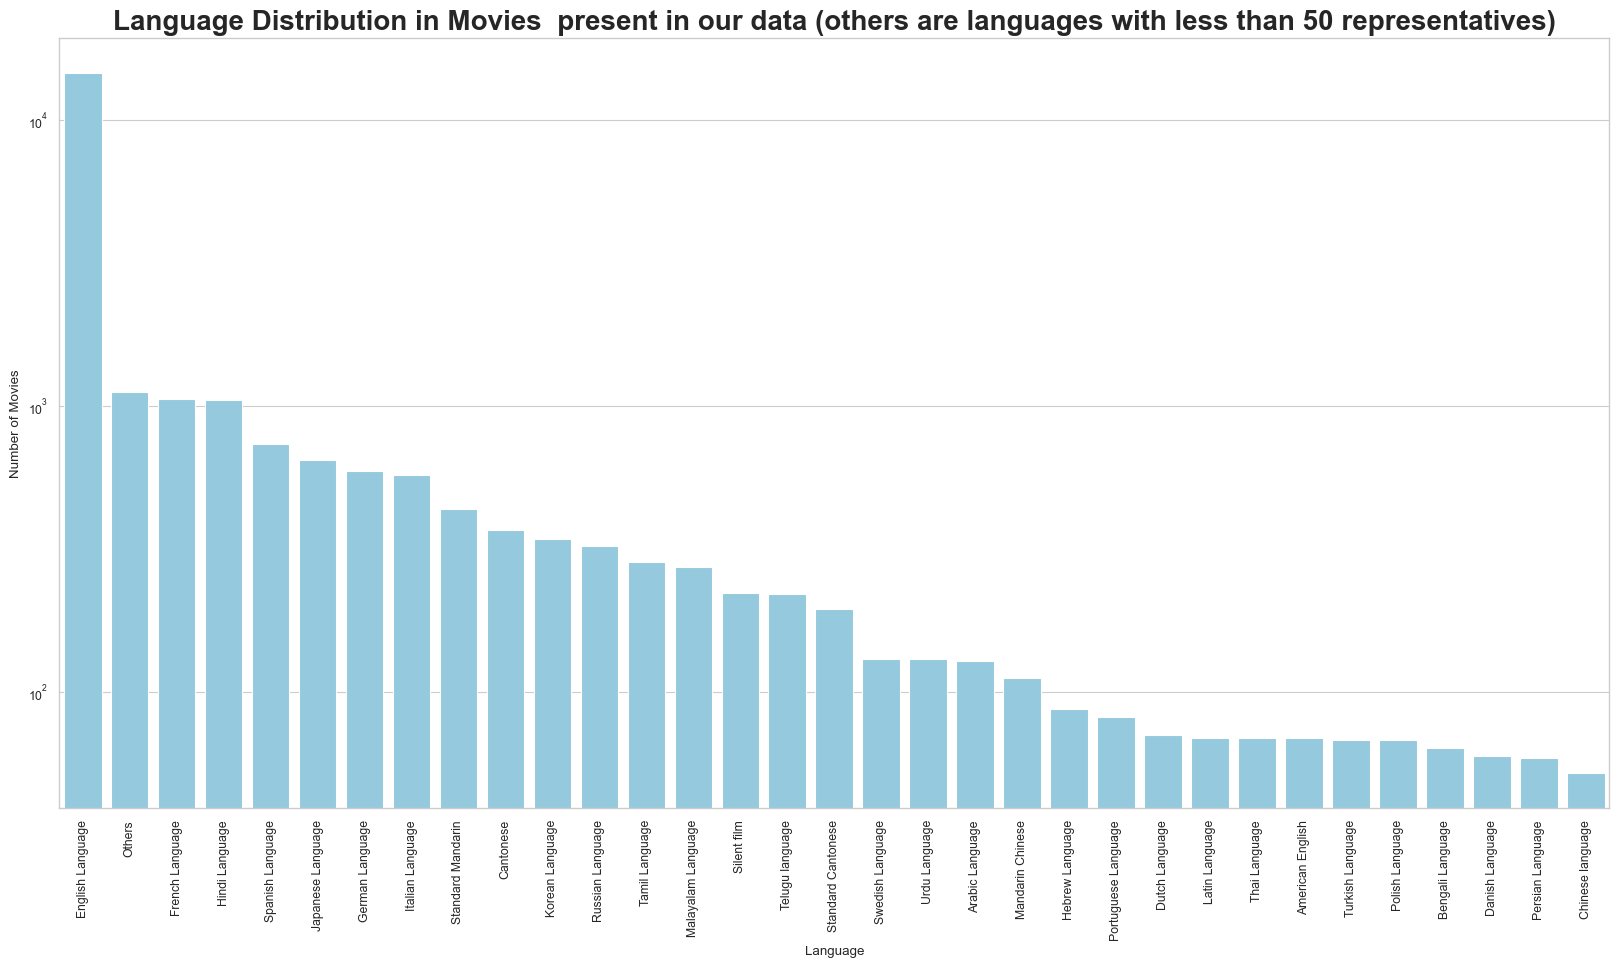

In [34]:
df = languages_ratings_df.copy()
threshhold = 50
df.loc[df['language_name'].value_counts()[df['language_name']].values < threshhold, 'language_name'] = 'Others'

# plot the histogram with log scale
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.title(f'Language Distribution in Movies  present in our data (others are languages with less than {threshhold} representatives)')
sns.countplot(data=df, 
              x='language_name',
              order=df['language_name'].value_counts().index,
              color='skyblue',
              log=True)
plt.xlabel('Language')
plt.ylabel('Number of Movies')
plt.show()

In [35]:
def json_to_values(json_text):
    """
    Convert a JSON string to a list of values.

    Parameters:
    json_text (str): The JSON string to be converted.

    Returns:
    list: A list of values extracted from the JSON string.
          Returns None if the JSON string is invalid.
    """
    
    try:
        json_data = json.loads(json_text)
        values_list = list(json_data.values())
        return values_list
    except json.JSONDecodeError:
        return None

In [36]:
def json_to_list_values(df, column_name):
    """
    Convert a column containing JSON strings to a list of values.

    Args:
        df (pandas.DataFrame): The DataFrame containing the column to be converted.
        column_name (str): The name of the column to be converted.

    Returns:
        pandas.DataFrame: A copy of the input DataFrame with the specified column converted to a list of values.
    """
    
    df_cop = df.copy()
    df_cop[column_name] = df_cop[column_name].apply(json_to_values)
    return df_cop

In [37]:
def plot_data(start, movies_ratings, nb_combined_genres=1, nb_genres=10):
    """
    Plots a histogram of the number of movies produced per genre in a given time period, along with the mean rating of each genre.

    Parameters:
    start (int): The start year of the time period to consider.
    movies_ratings (pandas.DataFrame): A DataFrame containing the movie ratings in column averageRating and genres in column movie_genres.
    nb_combined_genres (int): The number of genres to consider together when finding popular combinations of genres. Default is 1.
    nb_genres (int): The number of genres to include in the plot. Default is 10.

    Returns:
    None
    """

    end = start + 10
    
    df = json_to_list_values(movies_ratings, 'movie_genres')
    #filter df to keep the rows with startYear < end and > start
    df = df[(df['movie_release_year'].astype(int)<end) & (df['movie_release_year'].astype(int)>start)]
    
    if nb_combined_genres > 1:
    #for finding popular combinations of genres
        df['movie_genres'] = df['movie_genres'].apply(lambda x: list(combinations(x, nb_combined_genres)))
        df['movie_genres'] = df['movie_genres'].apply(lambda x: [', '.join(i) for i in x])

    df = df.explode('movie_genres')
    df = df[['averageRating', 'movie_genres']]
    df['count'] = df.groupby('movie_genres')['movie_genres'].transform('count')
    df = df.groupby(['movie_genres']).mean()
    #add a 'count' column to the dataframe
    df = df.sort_values(by=['count'], ascending=False)
    #plot a hisstogram of the first 10 genres with the most movies 
    
    plt.figure(figsize=(16, 3))
    plt.bar(df.index[:nb_genres], df['count'][:nb_genres], width=0.5, color='skyblue')
    #print the mean rating of the first nb_genres genres on the histogram 
    for i, genre in enumerate(df.index[:nb_genres]):
        mean_rating = df.loc[genre, 'averageRating']
        plt.text(i, df['count'][i] + 1, f'rating: {mean_rating:.2f}', ha='center', va='bottom')

    plt.xlabel('Genre')
    plt.ylabel('Number of Movies prodduced')
    plt.title('Number of Movies per Genreprodudced in the period {}-{}'.format(start, end))
    plt.show()

In [38]:
interact(plot_data, 
         start=IntSlider(value=2000, min=1900, max=2010, step=10), 
         movies_ratings=fixed(movies_metadata_ratings_df), 
         nb_combinations=IntSlider(min=1, max=3, step=1), 
         nb_genres=IntSlider(value=7,min=1, max=15, step=1), 
         nb_combined_genres=IntSlider(min=1, max=4, step=1)
)

interactive(children=(IntSlider(value=2000, description='start', max=2010, min=1900, step=10), IntSlider(value…

<function __main__.plot_data(start, movies_ratings, nb_combined_genres=1, nb_genres=10)>

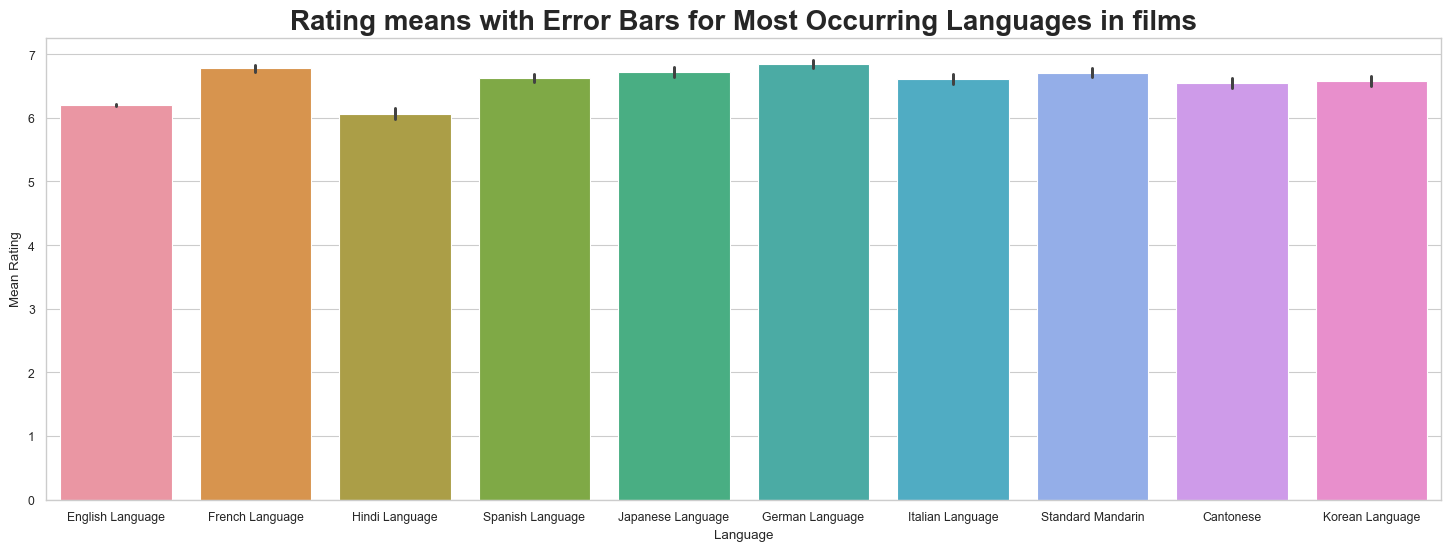

In [39]:
# Group by 'name' and calculate mean and standard deviation
grouped_df = languages_ratings_df.groupby('language_name')['averageRating'].agg(['mean', 'std', 'count'])

# Find the most occurring names
top_names = grouped_df['count'].nlargest(10).index

# Filter the DataFrame for the top names
filtered_df = languages_ratings_df[languages_ratings_df['language_name'].isin(top_names)]

# Group by 'name' again for plotting
plot_data = filtered_df.groupby('language_name')['averageRating']

# Plotting
plt.figure(figsize=(18, 6))
sns.barplot(x='language_name', 
            y='averageRating', 
            data=filtered_df, 
            estimator=np.mean, 
            errorbar=('ci', 95), 
            order=top_names)
plt.xlabel('Language')
plt.ylabel('Mean Rating')
plt.title('Rating means with Error Bars for Most Occurring Languages in films')
plt.show()

In [40]:
def t_test_on_language(language_to_test, df, elim_English=False):
    """
    Performs a two-sample t-test to compare the mean rating of movies in a given language to the mean rating of movies in all other languages.

    Parameters:
    language_to_test (str): The name of the language to test.
    df (pandas.DataFrame): A DataFrame containing the movie ratings in column averageRating and languages in column language_name.
    elim_English (bool): Whether to exclude English language films from the analysis. Default is False.

    Returns:
    statistic (float): The t-statistic of the test.
    p_value (float): The p-value of the test.
    """


    if elim_English:
        df = df[languages_ratings_df['language_name'] != 'English Language'].copy()
        if language_to_test == 'English Language':
            print("English films have been removed, so no test can be performed")
            return
   # Split the data into two groups: a and all others
    group_a = df[df['language_name'] == language_to_test]['averageRating']
    group_others = df[df['language_name'] != language_to_test]['averageRating']
    # Perform the t-test
    statistic, p_value = stats.ttest_ind(group_a, group_others)  
    return statistic, p_value

In [41]:
def plot_p_values(p_values):
    """
    Plots the p-values of two-sample t-tests comparing the mean rating of movies in a given language to the mean rating of movies in all other languages.

    Parameters:
    p_values (dict): A dictionary containing the p-values of the t-tests, with language names as keys and p-values as values.

    Returns:
    None
    """

    # plot the p-values with log scale
    plt.figure(figsize=(20,10))
    plt.xticks(rotation=45)
    plt.title('Mann-Whitney U Test P-Values for Each Language Compared to All Others (Including English)')
    sns.barplot(x=list(p_values.keys()), y=list(p_values.values()), color='skyblue', log=True)
    plt.axhline(y=0.05, color='red', linestyle='--')
    plt.text(0, 0.05, 'Significance Level', ha='right', va='bottom', color='red', fontsize=14, fontweight='bold')
    plt.xlabel('Language')
    plt.ylabel('P-Value')
    plt.show()

In [43]:
#collecting mann_whitney_u_test data on popular languages
languages_to_test =  ['English Language', 
                      'French Language', 
                      'German Language', 
                      'Italian Language', 
                      'Spanish Language', 
                      'Japanese Language', 
                      'German Language', 
                      'Standard Mandarin', 
                      'Korean Language', 
                      'Russian Language', 
                      'Cantonese']

#create an emty map with key language ans value p-value
p_values_with_eng = {}
p_values_without_eng = {}
for language_to_test in languages_to_test:
    p_values_with_eng[language_to_test] = t_test_on_language(language_to_test, languages_ratings_df)[1]
for language_to_test in languages_to_test:
    if language_to_test == 'English Language':
        continue
    p_values_without_eng[language_to_test] = t_test_on_language(language_to_test, languages_ratings_df, elim_English=True)[1]

Preforming Mann-Whitney U tests showed that if we account leave the english language in the pool of 'other' samples, runniing a Mann-Whitney U test yields a verry small p-value. Removing english shows that some languages tend to get a rather significant p-value, signifying that there may after all be a general tendancy to grade, not specific to each language.

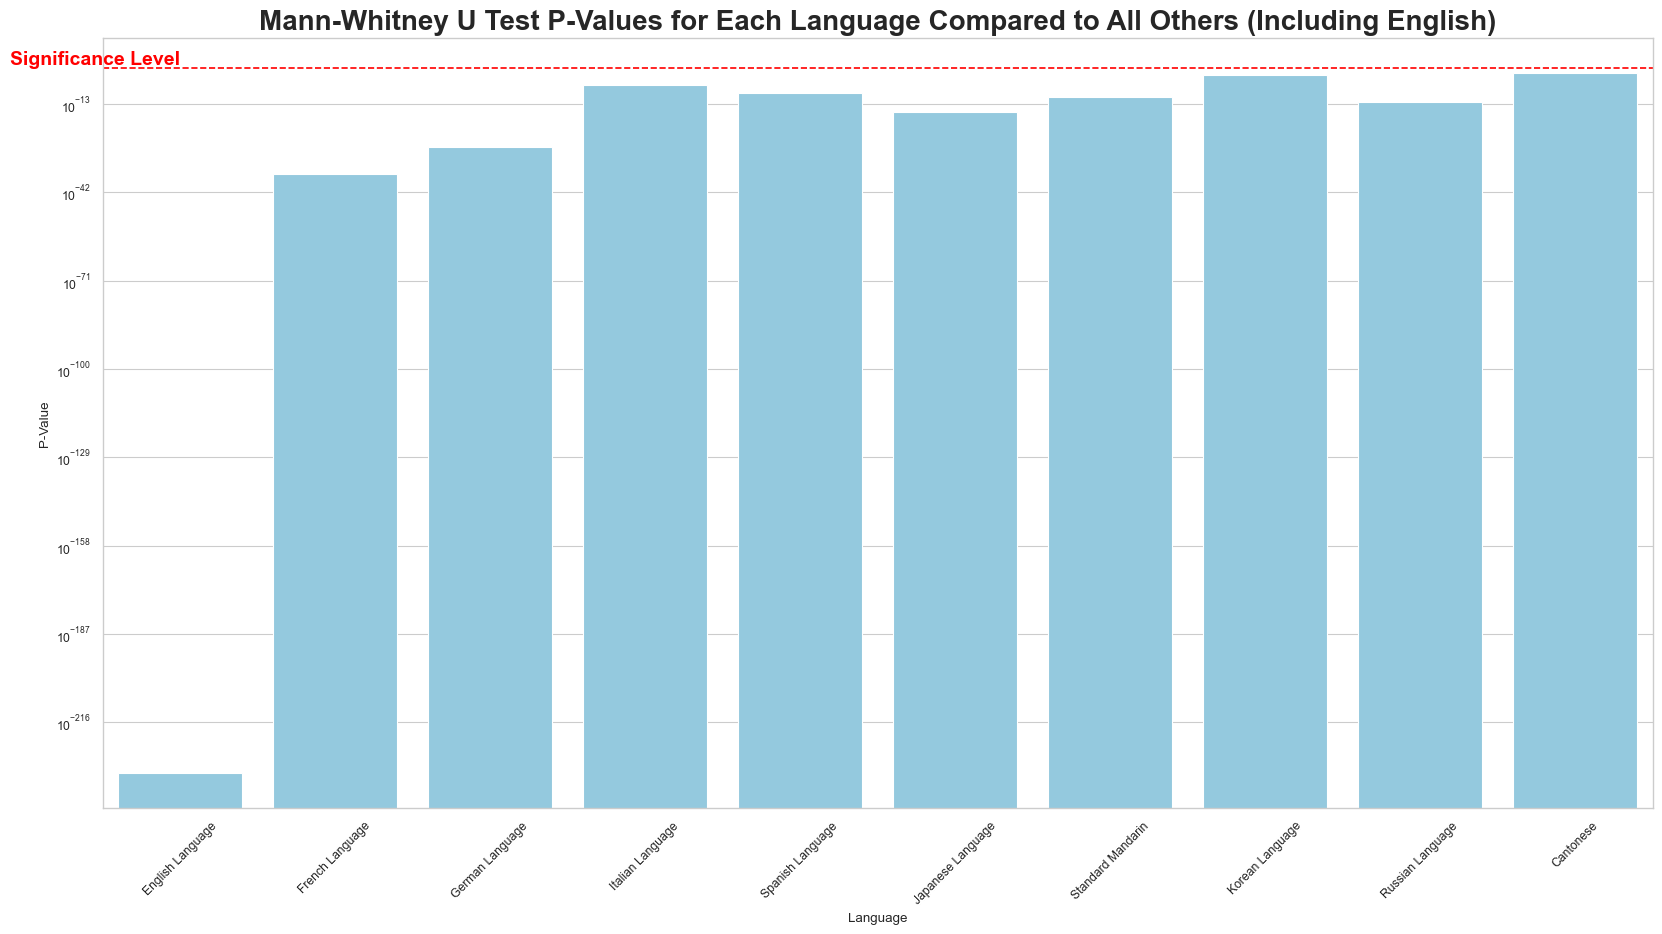

In [44]:
plot_p_values(p_values_with_eng)

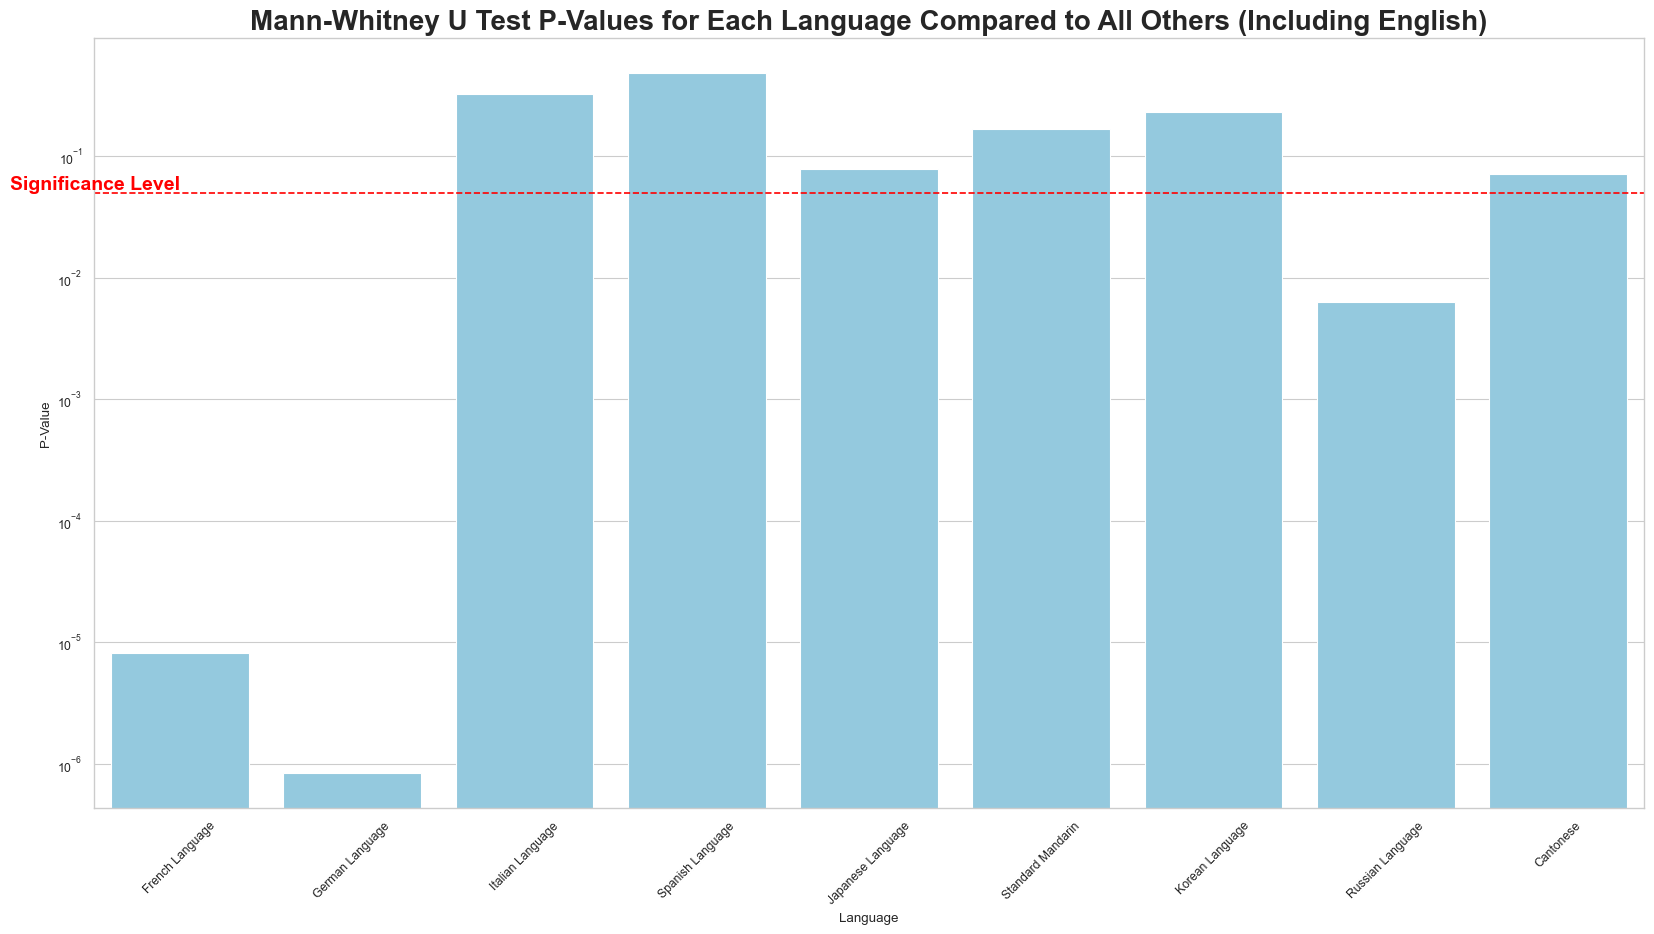

In [45]:
plot_p_values(p_values_without_eng)

In [46]:
reduced_languages_ratings_df = languages_ratings_df.head(2000)
#save to csv
reduced_languages_ratings_df.to_csv('data/RESULTS/erase_this_language.csv', index=False)

## **2. Keep it Under the Radar!**

Now, one might think that the only way for a movie to get succes on IMDb is to create a huge succes on terms of vues or make it **contreversial** so that it gets more intrest from reviewers. Well the truth might be **decieving** ...

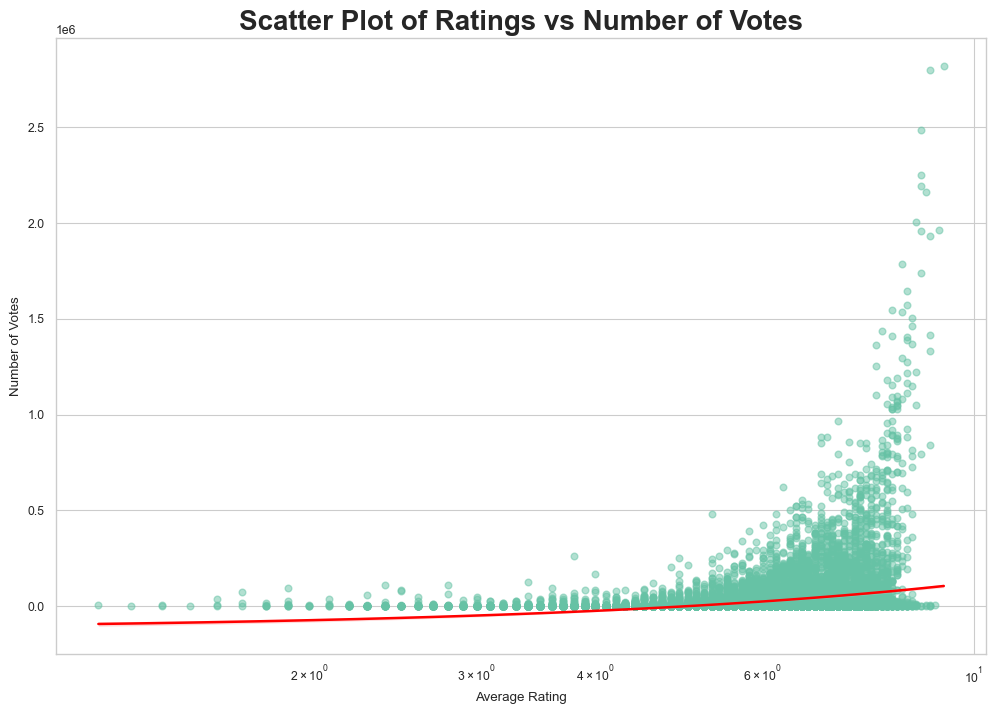

In [47]:
selected_columns = ['numVotes', 'averageRating']
votes_rating_data = movies_metadata_ratings_df[selected_columns]
# Drop rows with missing values (if any)
votes_rating_data = votes_rating_data.dropna()

# Create a scatter plot
plt.figure(figsize=(12, 8))
sns.regplot(x='averageRating', 
            y='numVotes', 
            data=votes_rating_data, 
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red'})

plt.title('Scatter Plot of Ratings vs Number of Votes')
plt.xlabel('Average Rating')
plt.ylabel('Number of Votes')
plt.xscale('log')  # Use log scale for the x-axis if needed
plt.show()

At first we can see here that High Rating doesn't implicate high number of votes. But let's try to fit a regression line into our data. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


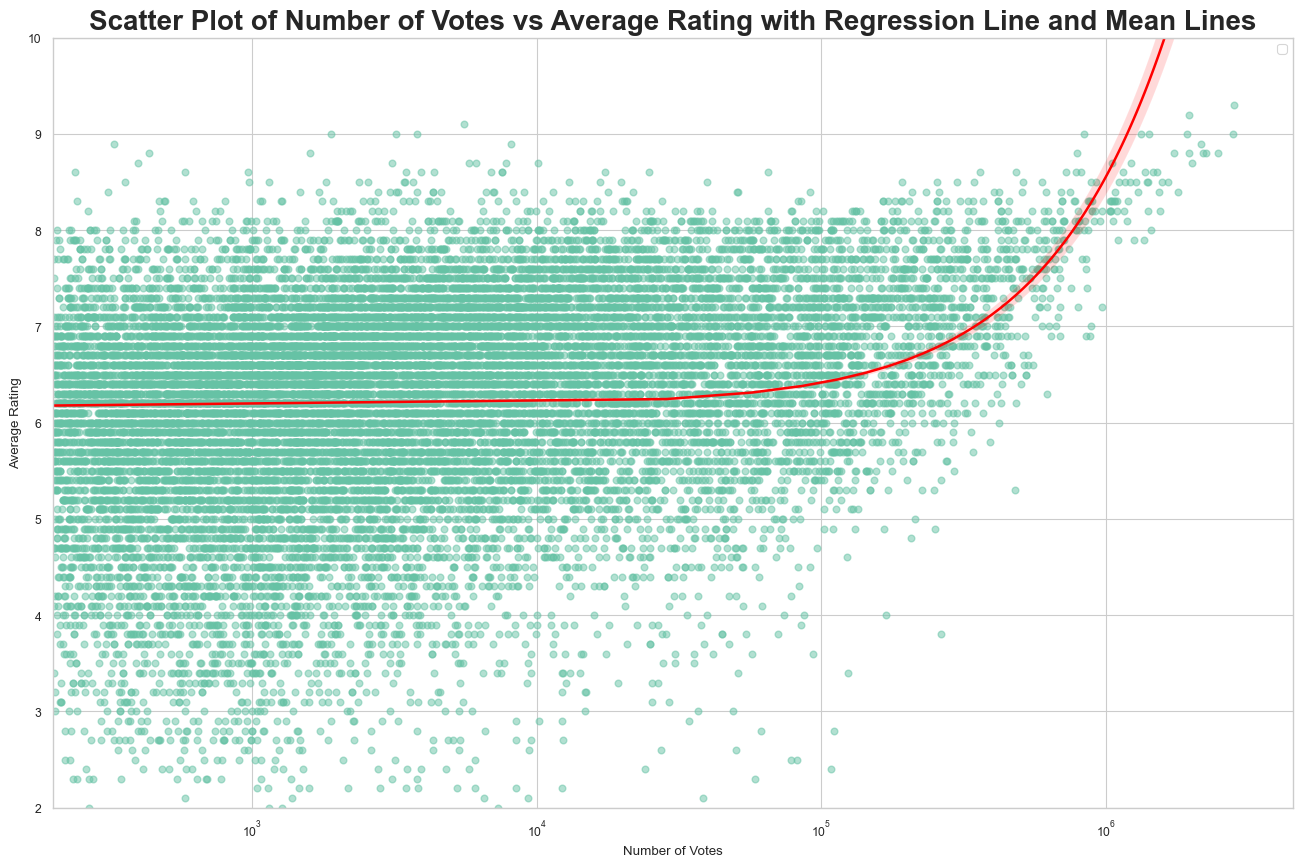

Pearson Correlation Coefficient: 0.24


In [48]:
# Filter relevant columns
selected_columns = ['numVotes', 'averageRating']
votes_rating_data_df = movies_metadata_ratings_df[selected_columns]

# Scatter plot with blue points and red regression line
plt.figure(figsize=(16, 10))
sns.regplot(data=votes_rating_data_df, x='numVotes', y='averageRating', scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})

# Calculate moving average for each vote number
window_size = 100  # You can adjust the window size according to your preference
moving_avg_by_vote_number = votes_rating_data_df.groupby('numVotes')['averageRating'].rolling(window=window_size).mean().reset_index(level=0, drop=True)

plt.title('Scatter Plot of Number of Votes vs Average Rating with Regression Line and Mean Lines')
plt.xlabel('Number of Votes')
plt.xscale('log')
plt.xlim(200)
plt.ylim(2, 10)
plt.ylabel('Average Rating')
plt.legend()  # Show the legend for mean lines
plt.show()

# Calculate Pearson correlation coefficient
correlation_coefficient = votes_rating_data_df['numVotes'].corr(votes_rating_data_df['averageRating'], method='pearson')
print(f"Pearson Correlation Coefficient: {correlation_coefficient:.2f}")


Now, this graph claims the **opposite** of the hypothesis we have just drown in the previous plot. 

We might need a deeper analysis on the **type of distribution** we are dealing with. Here the idea is to divide the data inty 5 bins based on the number of votes and see how the rating is distributed in each bin. 

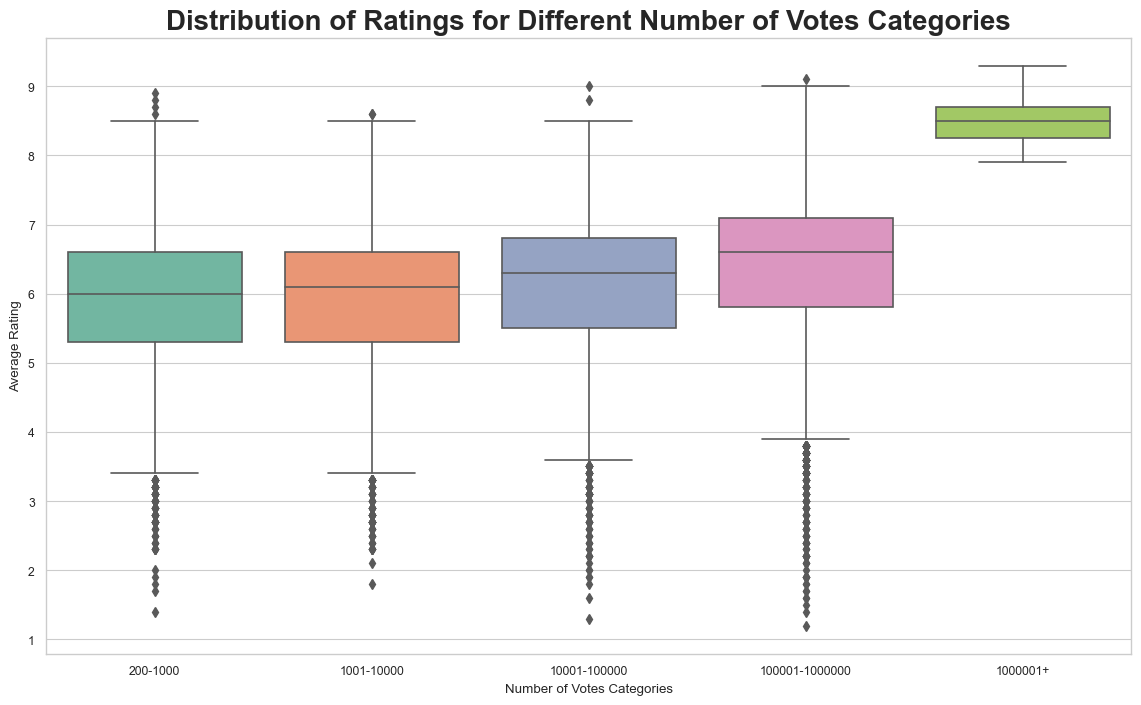

In [49]:
# Filter relevant columns
selected_columns = ['numVotes', 'averageRating']
votes_rating_data_df = movies_metadata_ratings_df[selected_columns]

# Drop rows with missing values (if any)
votes_rating_data_df = votes_rating_data_df.dropna()

# Create a new column for vote number categories (you can adjust the bin edges)
bins = [200, 500, 1000, 2000, 100000,1000000, float('inf')]
votes_rating_data_df['numVotesCategory'] = pd.cut(votes_rating_data_df['numVotes'], bins=bins, labels=['200-1000', '1001-10000', '10001-100000', '100001-1000000', '100001-100000', '1000001+'])

# Create a box plot to compare the distribution of ratings for different vote number categories
plt.figure(figsize=(14, 8))
sns.boxplot(x='numVotesCategory', y='averageRating', data=votes_rating_data_df, order=['200-1000', '1001-10000', '10001-100000', '100001-1000000', '1000001+'])
plt.title('Distribution of Ratings for Different Number of Votes Categories')
plt.xlabel('Number of Votes Categories')
plt.ylabel('Average Rating')
plt.show()

Now we can have a clearer conclusion which is that starting at a certain thershold of number of votes the rating will always be high. 

But this also means that under that threshold the number of votes won't affect that much your rating, hence, keeping your movie under the radar might be the best way to increase your rating.

In [50]:
# Calculate yearly stats across movies 
stats_by_year_df = movies_metadata_ratings_df.groupby(movies_metadata_ratings_df['movie_release_year']).apply(lambda x: pd.Series({
        'average_worldwide_rating': x['averageRating'].mean(),
        'std_dev_worldwide_rating': x['averageRating'].std()
    }))

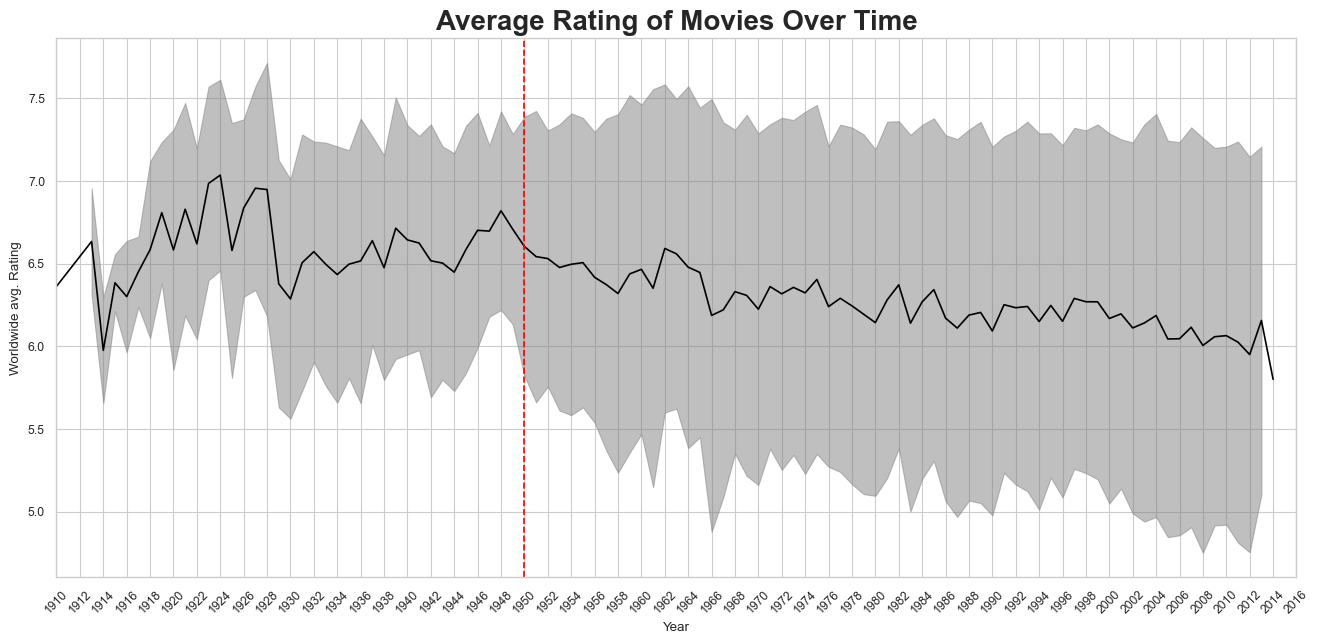

In [51]:
plt.figure(figsize=(16, 7))
plt.fill_between(stats_by_year_df.index, stats_by_year_df.average_worldwide_rating - stats_by_year_df.std_dev_worldwide_rating,
                 stats_by_year_df.average_worldwide_rating + stats_by_year_df.std_dev_worldwide_rating, alpha = 0.5, color = 'gray')

plt.plot(stats_by_year_df.average_worldwide_rating, color = 'black')
plt.axvline(x=1950, color='red', linestyle='--', label='Transition to colored movies')

plt.xlabel('Year')
plt.xlim(1910, 2016)
plt.xticks(range(1910, 2016 + 1, 2))
plt.xticks(rotation=45)
plt.ylabel('Worldwide avg. Rating')
plt.title('Average Rating of Movies Over Time')
plt.show()

From this plot, we can conclude that ratings are in a decreasing trend, so if your movie wasn't released in the early 90's it is unlikely that you can hack the system.
Another intresting insight from this plot is that this trend began on 1950s, the years that marked a more widespread adoption of color in the film industry. 
You might need to use black and white visuals in your production to take advantage of this fact.

We define the `movie_countries_df` dataframe, which contains the countries of movies. We construct this dataframe by reading the `movie_countries` column from the `movie_metadata_ratings_df` dataframe. This column contains a dictionary of country_id and country_name. We then extract the country_name and add it to the a new column called `movie_countries`.

In [52]:
#create a dataframe with only the movie countries
movie_countries_df = movie_metadata_df[['freebase_movie_id', 'movie_countries']]
movie_countries_df['movie_countries'] = movie_metadata_df['movie_countries'].apply(json.loads)
movie_countries_df['movie_countries'] = movie_countries_df['movie_countries'].apply(lambda x: x.values())
movie_countries_df = movie_countries_df.explode('movie_countries')
movie_countries_df.rename(columns={'movie_countries':'movie_countrie'}, inplace=True)
movie_countries_df.head()

,freebase_movie_id,movie_countrie
0,/m/03vyhn,United States of America
4,/m/01mrr1,Germany
13,/m/016ywb,United Kingdom
17,/m/0kcn7,United States of America
22,/m/05p45cv,United States of America


We define the `movie_genres_df` dataframe, which contains the genres of movies. We construct this dataframe by reading the `movie_genres` column from the `movie_metadata_ratings_df` dataframe. This column contains a dictionary of genre_id and genre_name. We then extract the genre_name and add it to the a new column called `movie_genres`.

In [53]:
#create a dataframe with only the movie genres
movie_genres_df = movie_metadata_df[['freebase_movie_id', 'movie_genres']]
movie_genres_df['movie_genres'] = movie_metadata_df['movie_genres'].apply(json.loads)
movie_genres_df['movie_genres'] = movie_genres_df['movie_genres'].apply(lambda x: x.values())
movie_genres_df = movie_genres_df.explode('movie_genres')
movie_genres_df.rename(columns={'movie_genres':'movie_genre'}, inplace=True)
movie_genres_df.head(10)

,freebase_movie_id,movie_genre
0,/m/03vyhn,Thriller
0,/m/03vyhn,Science Fiction
0,/m/03vyhn,Horror
0,/m/03vyhn,Adventure
0,/m/03vyhn,Supernatural
0,/m/03vyhn,Action
0,/m/03vyhn,Space western
4,/m/01mrr1,Drama
13,/m/016ywb,Costume drama
13,/m/016ywb,War film


In [54]:
def get_wikidata_id(freebase_id):
  """
  Given a Freebase ID, returns the corresponding Wikidata ID and label in English.

  Parameters:
  freebase_id (str): The Freebase ID to look up.

  Returns:
  str: The label of the corresponding Wikidata ID in English, or None if no match is found.
  """


  sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
  query = f"""
  SELECT ?article ?label
  WHERE 
  {{
    ?article schema:about ?item;
        schema:isPartOf <https://en.wikipedia.org/> .
    ?item wdt:P646 "{freebase_id}";
          rdfs:label ?label.
    FILTER(LANG(?label) = "en") # Optional: Filter by English labels
  }}
  """
  sparql.setQuery(query)
  sparql.setReturnFormat(JSON)
  
  try:
      results = sparql.query().convert()
      if 'results' in results and 'bindings' in results['results'] and len(results['results']['bindings']) > 0:
          return results['results']['bindings'][0]['label']['value']
  except Exception as e:
      print(f"Error: {e}")
      time.sleep(20)
      return get_wikidata_id(freebase_id)
  
  return None

In [55]:
#extract the actor ethnicity into a Series from the character metadata removing duplicates
actor_ethnicity_df = character_metadata_df["actor_ethnicity"].drop_duplicates().dropna().reset_index(drop=True)

We define the `ethnicities_names_df` 

In [56]:
#create a dataframe from the results of the sparql query from every element in actor_ethnicity_series
ethnicities_name_filename = 'data/RESULTS/ethnicities_name.csv'

if os.path.exists(ethnicities_name_filename):
    ethnicities_name_df = pd.read_csv(ethnicities_name_filename)
else:
    ethnicity_queried_values = [get_wikidata_id(value) for value in actor_ethnicity_df]
    ethnicities_name_df = pd.DataFrame({'ethnicity_id': actor_ethnicity_df, 'ethnicity_name': ethnicity_queried_values})
    # save to csv
    ethnicities_name_df.to_csv(ethnicities_name_filename, index=False)

print

<function print>

In [57]:
# merge character_metadata_df with df on actor_ethnicity and ethnicity_name
character_metadata_df = pd.merge(character_metadata_df, ethnicities_name_df, 
                                 left_on='actor_ethnicity', 
                                 right_on='ethnicity_id', 
                                 how='left')

character_metadata_df.drop(columns=["ethnicity_id"], inplace=True)
character_metadata_df.rename(columns={'actor_ethnicity': 'actor_ethnicity_id', 'ethnicity_name':'actor_ethnicity', }, inplace=True)
character_metadata_df.head(10)

,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,movie_release_year,actor_ethnicity
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0,African Americans
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001.0,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001.0,NaN
5,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft,2001.0,African Americans
6,975900,/m/03vyhn,2001-08-24,Whitlock,1945-08-02,F,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw,/m/0bgchmx,/m/06lj1m,2001.0,NaN
7,975900,/m/03vyhn,2001-08-24,Big Daddy Mars,NaN,M,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy,/m/0bgcht0,/m/0bgcht7,2001.0,NaN
8,975900,/m/03vyhn,2001-08-24,Michael Descanso,1971-03-20,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0,2001.0,NaN
9,975900,/m/03vyhn,2001-08-24,Uno,NaN,M,NaN,NaN,Duane Davis,NaN,/m/0bgchtj,/m/0bgchtm,/m/03nrwdy,2001.0,NaN


In [58]:
#characters that have been played by multiple actors
character_metadata_df[character_metadata_df['character_name'].duplicated(keep=False)].sort_values(by=['character_name'])

,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,movie_release_year,actor_ethnicity
72346,747689,/m/037_84,1979-03-14,'3-5-0-0' Soloist,1950-06-05,M,NaN,NaN,Ronnie Dyson,28.0,/m/0gy_y5r,/m/0h5rdn3,/m/01p27qd,1979.0,NaN
72331,747689,/m/037_84,1979-03-14,'3-5-0-0' Soloist,1945-10-29,F,NaN,/m/0x67,Melba Moore,33.0,/m/0cg6hqj,/m/0h5rdnt,/m/08rgr4,1979.0,African Americans
15754,673694,/m/031tc2,1988-08-10,'Jose' Chavez y Chavez,1962-02-17,M,1.85,/m/03295l,Lou Diamond Phillips,26.0,/m/02vcg9t,/m/0h2k5dk,/m/031zkw,1988.0,Filipino Americans
11936,675213,/m/031zk3,1990-08-01,'Jose' Chavez y Chavez,1962-02-17,M,1.85,/m/03295l,Lou Diamond Phillips,28.0,/m/02vc4lz,/m/0h2k5dk,/m/031zkw,1990.0,Filipino Americans
74539,28370864,/m/0crfcdl,2011-08-12,'Juicy' Judy Gonzalez,1977-03-26,F,1.73,NaN,Bianca Kajlich,34.0,/m/0gvd8fd,/m/0cgm75g,/m/0dlbpj,2011.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192520,22330502,/m/05sync6,1931-01-31,NaN,1889-07-15,F,NaN,NaN,Marjorie Rambeau,NaN,/m/05tg4vt,NaN,/m/079q2l,1931.0,NaN
192521,24997872,/m/09g6klx,2010-05-07,NaN,1972-09-09,M,NaN,/m/01rv7x,Riyaz Khan,37.0,/m/0h888_7,NaN,/m/04645zm,2010.0,Tamil
192525,24997872,/m/09g6klx,2010-05-07,NaN,1944-08-01,M,NaN,/m/01rv7x,Delhi Ganesh,65.0,/m/0h6krrl,NaN,/m/04cw5sb,2010.0,Tamil
192526,24997872,/m/09g6klx,2010-05-07,NaN,1948-05-22,M,NaN,/m/04mvp8,Nedumudi Venu,61.0,/m/0h7yl4y,NaN,/m/02hkw6,2010.0,Malayali


## **3. Movie runtime and average rating**

In [59]:
movie_runtime_rating_df = movies_metadata_ratings_df[['movie_runtime','averageRating']]
filtered_movie_runtime_rating_df = movie_runtime_rating_df[movie_runtime_rating_df['movie_runtime'] < 400]
movie_runtime_rating_df.head()

,movie_runtime,averageRating
0,98.0,4.9
3,106.0,5.9
8,137.0,7.5
9,139.0,7.8
13,82.0,6.1


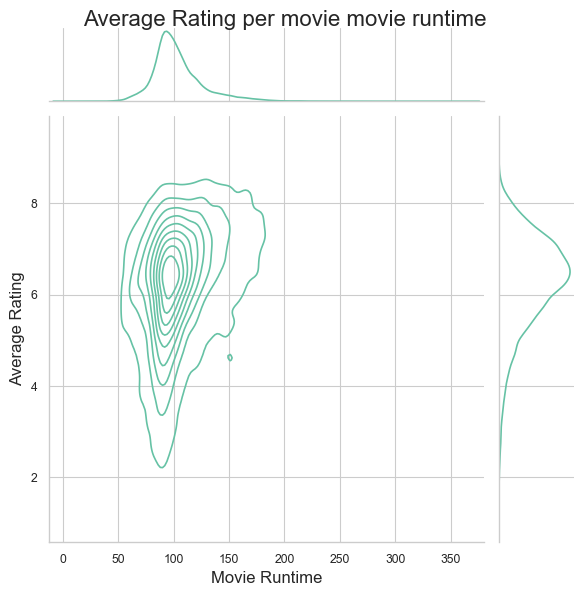

In [60]:
g = sns.jointplot(x=filtered_movie_runtime_rating_df['movie_runtime'], 
                  y=filtered_movie_runtime_rating_df['averageRating'], 
                  kind='kde', 
                  height=6)

# Set labels and title
g.set_axis_labels('Movie Runtime', 'Average Rating', fontsize=12)
g.fig.suptitle('Average Rating per movie movie runtime ', fontsize=16)
g.fig.subplots_adjust(top=0.95)

In [61]:
correlation_coefficient, p_value = stats.pearsonr(filtered_movie_runtime_rating_df['movie_runtime'], 
                                            filtered_movie_runtime_rating_df['averageRating'])
print(f"Correlation Coefficient: {correlation_coefficient}")
print(f"P-Value: {p_value}")

Correlation Coefficient: 0.2566673074667025
P-Value: 7.922684158864968e-287


## Interpretation

The obtained p-value indicate that the correlation coeficient observed is statisticlly significant, meaning that is almost impossible to observe such result by random chance. The correlation coefficient 0.227 indicate a small positif linear relationship meaning that when the movie runtime increases, there is a tendency for the average rating to also increase slightly. However, our correlation coefficient is relatively small, thus it is indicating that movie runtime alone does not explain a large portion of the variability in average ratings.

The density of contours around the center suggests that a majority of movies have a runtime between approximately 90 to 150 minutes and these movies tend to have a wide range of ratings. However, there is a noticeable concentration of higher ratings (between 6 and 8 on average) for movies that fall within this runtime range. The peak of the distribution for average ratings also seems to correspond to a movie runtime of around 100 to 120 minutes, indicating that this duration is optimal for achieving higher ratings.

There are fewer movies with short or very long runtimes.The contour lines spread wider at the extremes, particularly for the longer runtime end, which suggests more variability in the ratings of movies with longer runtimes. This indicate that while longer movies have the potential to achieve high ratings, it is less consistent.

Movie runtime is an important parameter because it needs to be sufficient enough to develop the plot and characters, but not to long that it risks losing the audience's attention. The sweet spot indicated that viewers may prefer these kind of movies.

## **4. Large Revenue Corelation With The IMDB Ratings**

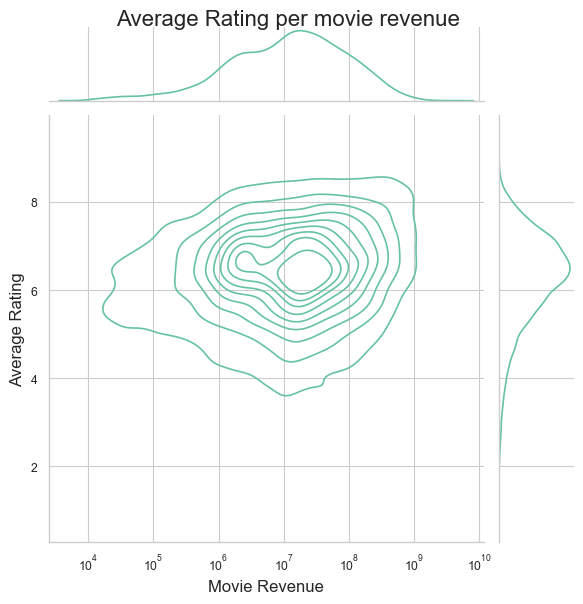

In [62]:
# plot the average rating per movie revenue
g = sns.jointplot(x=movies_metadata_ratings_df['movie_box_office_revenue'],
              y=movies_metadata_ratings_df['averageRating'],
              kind='kde',
              height=6,
              log_scale=(True, False))

# Set labels and title
g.set_axis_labels('Movie Revenue', 'Average Rating', fontsize=12)
g.fig.suptitle('Average Rating per movie revenue', fontsize=16)
g.fig.subplots_adjust(top=0.95)

## **5. Linking events to movies** 

in this section we are going to try to link movie summaries with historical events, to do that we chose to use the BERT-Large model from hugging face.
- first we tokenize the event description, then we compute the embeddings for this description
- then we tokenize the summary and we compute the embeddings for this summary

In [63]:
import torch
from transformers import BertTokenizer, BertModel

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-Large-cased')
model = BertModel.from_pretrained('bert-large-cased')

# Function to tokenize and encode text
def encode(text, max_length=512):
    """
    Encodes the given text into a BERT embedding.

    Parameters:
    text (str): The text to encode.
    max_length (int): The maximum length of the input sequence. Defaults to 512.

    Returns:
    torch.Tensor: The BERT embedding of the input text.
    """

    # Subtract 2 for [CLS] and [SEP] tokens
    if len(text) == 0:
        print("Empty text")  # Debugging
    
    max_length -= 2
    tokens = tokenizer.tokenize(text)
    if len(tokens) == 0:
        print("Empty tokens")  # Debugging
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]
    if not chunks:  # Check if chunks are empty
        print(f"No chunks for text: {text}")  # Debugging

    # Process each chunk
    chunk_embeddings = []
    for chunk in chunks:
        # Add special tokens
        chunk = ['[CLS]'] + chunk + ['[SEP]']
        input_ids = tokenizer.convert_tokens_to_ids(chunk)
        input_tensor = torch.tensor([input_ids]).to('cuda' if torch.cuda.is_available() else 'cpu')
        with torch.no_grad():
            last_hidden_states = model(input_tensor)[0]  # Get the embeddings
        chunk_embeddings.append(last_hidden_states[0].mean(dim=0))

    # Aggregate the embeddings from each chunk (mean pooling here)
    embeddings = torch.mean(torch.stack(chunk_embeddings), dim=0)
    return embeddings

In [64]:
# the embedding is made in another notebook because it took 20 h to run

Create event description embeddings

In [65]:
events_embeddings_filename = 'data/EMBEDDINGS/events_embeddings.csv'

if not os.path.exists(events_embeddings_filename):
    # Tokenize, encode, and get embeddings
    events_df['Embeddings'] = events_df['Event Description'].apply(lambda x: encode(x).tolist() if pd.notnull(x) else None)
    
    #save the embeddings of events as a csv file
    events_df.to_csv('data/RESULTS/events_embeddings.csv', index=False)


Create movie summary plot emberddings

In [66]:
plot_summaries_embeddings_filename = 'data/EMBEDDINGS/plot_summaries_embeddings.csv'

if not os.path.exists(plot_summaries_embeddings_filename):
    # add a column to the plot_summaries_df with embedding of the summary
    plot_summaries_df['Embeddings'] = plot_summaries_df['plot_summary'].apply(lambda x: encode(x).tolist() if pd.notnull(x) else None)

    #save the embeddings of summaries as a csv file
    plot_summaries_df.to_csv('data/plot_summaries_embeddings.csv', index=False)

Load the event embeddings and summaries embeddings

In [67]:
# Function to convert string representation back to list
def string_to_tensor(string):
    """
    Convert a string representation of a tensor back to a tensor object.

    Parameters:
    string (str): The string representation of the tensor.

    Returns:
    torch.Tensor or None: The tensor object if the conversion is successful, None otherwise.
    """

    try:
        return torch.tensor(ast.literal_eval(string))
    except ValueError:
        return None

events_embedded_df = pd.read_csv(events_embeddings_filename)
# Convert string representation back to tensor
events_embedded_df['Embeddings'] = events_embedded_df['Embeddings'].apply(string_to_tensor)

summaries_embedded_df = pd.read_csv(plot_summaries_embeddings_filename)
# Convert string representation back to tensor
summaries_embedded_df['Embeddings'] = summaries_embedded_df['Embeddings'].apply(string_to_tensor)

Link every movie summary with an event

In [68]:
#create a merged dataset with the movie metadata and the summaries(with the embeddings)
merged_movie_df = pd.merge(summaries_embedded_df, 
                           movies_metadata_ratings_df, 
                           on='wiki_movie_id', 
                           how='inner')

# Function to calculate cosine similarity manually
def calculate_similarity(a, b):
    """
    Calculates the cosine similarity between two vectors.

    Parameters:
    a (array-like): The first vector.
    b (array-like): The second vector.

    Returns:
    float: The cosine similarity between the two vectors.
    """

    similarity = 1 - cosine(a, b)
    return similarity

In [69]:
def match_event_from_summary_embeddings(movie_embedding, movie_release_year):
    """
    Given a movie embedding and its release year, finds the event that is most similar to the movie based on the embeddings of their summaries.

    Parameters:
    movie_embedding (torch.Tensor): The BERT embedding of the movie summary.
    movie_release_year (str): The year the movie was released.

    Returns:
    tuple: A tuple containing the similarity score between the movie and the most similar event, and the name of the most similar event.
    """

    # Filter events that happened before the movie was released (at least 2 years since it takes time to make a movie)
    filtered_events = events_embedded_df[events_embedded_df['Year'] < (int(movie_release_year)-2)]
    # Calculate the similarity between the movie and all events
    similarities = filtered_events['Embeddings'].apply(lambda x: calculate_similarity(movie_embedding, x))
    # Get the index of the most similar event
    index = similarities.idxmax()
    # Get the similarity score of the most similar event
    similarity = similarities[index]
    # Get the name of the most similar event
    matched_event_name = filtered_events.loc[index]['Event Name']
    return similarity, matched_event_name

In [70]:
linked_movies_and_events_filename = 'data/RESULTS/linked_movies_and_events_df.csv'

if not os.path.exists(linked_movies_and_events_filename):
    # Initialize an empty list to store movie data
    linked_movies_events = []

    # Loop through each movie
    for index, movie in merged_movie_df.iterrows():
        # Your existing logic to get movie_embedding, movie_release_year, similarity, and matched_event
        movie_embedding = movie['Embeddings']
        movie_release_year = movie['movie_release_year']
        similarity, matched_event = match_event_from_summary_embeddings(movie_embedding, movie_release_year)
        event_description = events_df[events_df['Event Name'] == matched_event]['Event Description'].values[0]

        # Create a dictionary for the current movie
        movie_data = {
            'wiki_movie_id': movie['wiki_movie_id'],
            'movie_name': movie['movie_name'],
            'plot_summary': movie['plot_summary'],
            'matched_event': matched_event,
            'event description': event_description,
            'similarity_score': similarity,
            'rating': movie['averageRating']
        }

        # Append the dictionary to the list
        linked_movies_events.append(movie_data)

    # Create a DataFrame from the list of dictionaries
    linked_movies_and_events_df = pd.DataFrame(linked_movies_events)

    #save the dataframe to csv
    linked_movies_and_events_df.to_csv(linked_movies_and_events_filename, index=False)

- lastly we compare the embedding of the movie summary with all the events embeddings and we pick the event that matches the most.

In [71]:
# the comparison is made in another notebook

after running the Bert model to get the embeddings and assigning each movie to an event we read the resulting file 

In [72]:
# read the linked_movies_and_events_df 
linked_movies_and_events_df = pd.read_csv(linked_movies_and_events_filename)

linked_movies_and_events_df.sort_values(by=['similarity_score'], ascending=False, inplace=True)

#save the dataframe to csv
linked_movies_and_events_df.to_csv(linked_movies_and_events_filename, index=False)

movies_related_to_events_df = linked_movies_and_events_df[linked_movies_and_events_df['similarity_score'] > 0.77]

movies_unrelated_to_events_df = linked_movies_and_events_df[linked_movies_and_events_df['similarity_score'] < 0.7]

we calculate the 

In [73]:
avearge_rating_all = linked_movies_and_events_df['rating'].mean()
avearge_rating_related = movies_related_to_events_df['rating'].mean()
avearge_rating_unrelated = movies_unrelated_to_events_df['rating'].mean()
print('Average rating of movies related to events: ', avearge_rating_related)
print('Average rating of movies unrelated to events: ', avearge_rating_unrelated)
print('Average rating of movies  ', avearge_rating_all)

# perform the t-test
stats.ttest_ind(movies_related_to_events_df['rating'], movies_unrelated_to_events_df['rating'])
# print the p-value
print('p-value: ', stats.ttest_ind(movies_related_to_events_df['rating'], movies_unrelated_to_events_df['rating'])[1])

Average rating of movies related to events:  6.31342229199372
Average rating of movies unrelated to events:  6.149867319861197
Average rating of movies   6.251343062082611
p-value:  2.0778564702913703e-06


We can see that the p-value is less than 0.05 so we can reject the null hyposesis.
- we can interpret that the fact that a movie is related to a historical event improves the IMDb rating.

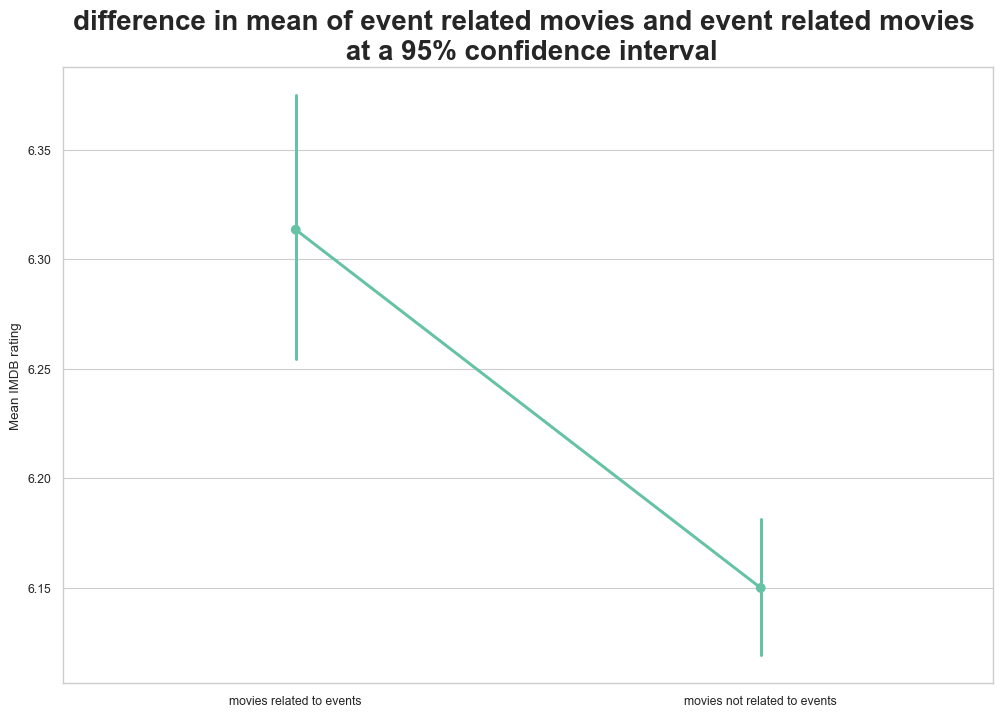

In [74]:
related_unrelated_movies = pd.DataFrame({'movies related to events': movies_related_to_events_df['rating'] , \
                                         'movies not related to events': movies_unrelated_to_events_df['rating']})

plt.figure(figsize=(12, 8))
# plot the mean salary for each throwing hand
sns.pointplot(data=related_unrelated_movies, errorbar=("ci", 95))
plt.title("difference in mean of event related movies and event related movies \n at a 95% confidence interval")
plt.ylabel("Mean IMDB rating")
plt.grid(axis='y', linestyle='-')
plt.show()

## **6. Evaluate the effect of Oscars nominations and wins on Movie sucess**

In [75]:
# keep freebase_character_id, actor_name, movie_release_year columns only
character_award_year_df = character_metadata_award_df[['freebase_character_id', 'actor_name', 'movie_release_year']]
character_award_year_df.head()

,freebase_character_id,actor_name,movie_release_year
271,NaN,Louise Dresser,1928.0
1177,NaN,Richard Barthelmess,1928.0
451,/m/0cfyb52,Gloria Swanson,1928.0
705,NaN,Emil Jannings,1928.0
789,NaN,George Bancroft,1929.0


In [76]:
# keep wiki_movie_id, actor_name, movie_release_year columns only
character_subset_df = character_metadata_df[['wiki_movie_id', 'freebase_character_id', 'actor_name', 'movie_release_year']]
#drop na in movie_release_year
character_subset_df = character_subset_df[character_subset_df['movie_release_year'].notna()]
character_subset_df

,wiki_movie_id,freebase_character_id,actor_name,movie_release_year
0,975900,/m/0bgcj3x,Wanda De Jesus,2001.0
1,975900,/m/0bgchn4,Natasha Henstridge,2001.0
2,975900,/m/0bgchn_,Ice Cube,2001.0
3,975900,/m/0bgchnq,Jason Statham,2001.0
4,975900,/m/0bgchp9,Clea DuVall,2001.0
...,...,...,...,...
192535,30553937,/m/0jxtp_8,Steve Monarque,1998.0
192536,30553937,/m/0jxtpzq,Kevin Richardson,1998.0
192537,30553937,/m/0jxtsvz,Leda Mulholland,1998.0
192538,30553937,/m/0jxtsx8,Randy Harris,1998.0


In [77]:
character_subset_award_year_df = pd.merge(character_subset_df, 
                                          character_award_year_df, 
                                          on=['freebase_character_id', 'actor_name'], 
                                          how='left', 
                                          suffixes=('', '_nominated'))

# remove rows there movie_release_year_nominated is na
character_subset_award_year_df = character_subset_award_year_df[character_subset_award_year_df['movie_release_year_nominated'].notna()]
# remove rows where movie_release_year smaller or equal to movie_year_nominated
character_subset_award_year_df = character_subset_award_year_df[character_subset_award_year_df['movie_release_year'] > character_subset_award_year_df['movie_release_year_nominated']]
# drop duplicates in the wiki_movie_id column
character_subset_award_year_df.drop_duplicates(subset=['wiki_movie_id'], inplace=True)
character_subset_award_year_df.head()

,wiki_movie_id,freebase_character_id,actor_name,movie_release_year,movie_release_year_nominated
132,4340003,NaN,James Gleason,1947.0,1941.0
144,1369204,NaN,Paul Muni,1939.0,1929.0
196,21209475,NaN,Leslie Howard,1934.0,1933.0
273,24863901,NaN,Diahann Carroll,2010.0,1974.0
412,1940449,NaN,Mako,1993.0,1966.0


In [78]:
# add a column in the movie_metadata_df for named awarded_character
movie_metadata_rating_df['nominated_character'] = movie_metadata_rating_df['wiki_movie_id'].isin(character_subset_award_year_df['wiki_movie_id'])

# make the awarded_character true if the movie is present in the df
movie_metadata_rating_df['nominated_character'] = movie_metadata_rating_df['nominated_character'].apply(lambda x: True if x else False)

movie_metadata_rating_df.head()

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,tconst,averageRating,numVotes,titleType,nominated_character
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,tt0228333,4.9,56920,movie,False
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0,tt0094806,5.6,40,movie,False
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0,tt0083949,5.9,623,movie,False
5,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938.0,tt0029852,6.8,2268,movie,False
6,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",1930.0,tt0021335,5.4,300,movie,False


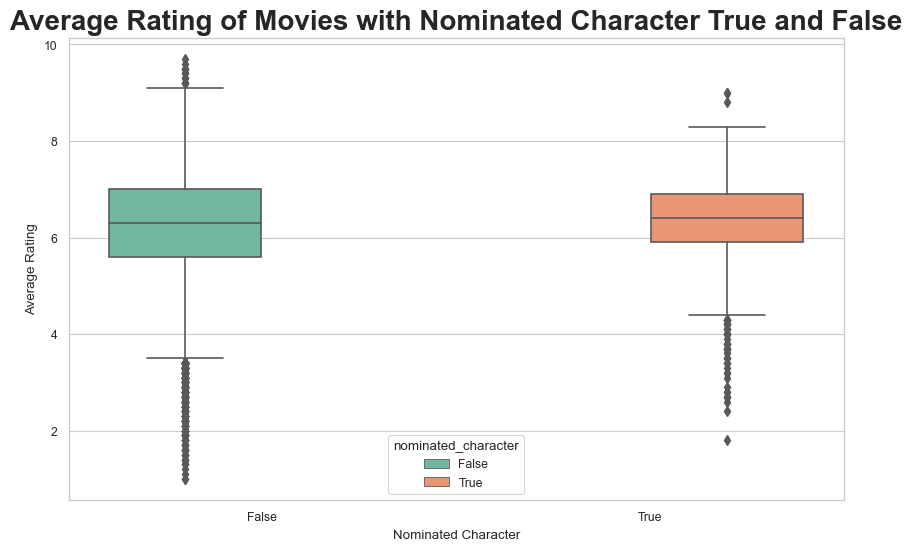

In [79]:
# plot the average rating of the movies with nominated_character true and false
plt.figure(figsize=(10, 6))
sns.boxplot(x='nominated_character', y='averageRating', data=movie_metadata_rating_df, hue='nominated_character')
plt.xlabel('Nominated Character')
plt.ylabel('Average Rating')
plt.title('Average Rating of Movies with Nominated Character True and False')
plt.show()

In [80]:
# drop characters that did not win an oscar
character_metadata_winner_df = character_metadata_award_df[character_metadata_award_df['winner'] == True]

# keep freebase_character_id, actor_name, movie_release_year columns only
character_winner_year_df = character_metadata_winner_df[['freebase_character_id', 'actor_name', 'movie_release_year']]
character_winner_year_df.head()

,freebase_character_id,actor_name,movie_release_year
705,NaN,Emil Jannings,1928.0
146,/m/0by5j17,Mary Pickford,1929.0
30,NaN,Warner Baxter,1929.0
349,NaN,Norma Shearer,1930.0
341,/m/0b_jnzp,George Arliss,1929.0


In [81]:
character_subset_winner_df = pd.merge(character_subset_df, 
                                      character_metadata_winner_df, 
                                      on=['freebase_character_id', 'actor_name'], 
                                      how='left', 
                                      suffixes=('', '_awarded'))

# remove rows there movie_release_year_y is na
character_subset_winner_df = character_subset_winner_df[character_subset_winner_df['movie_release_year_awarded'].notna()]
# remove rows where movie_release_year_x smaller or equal to movie_release_year_y
character_subset_winner_df = character_subset_winner_df[character_subset_winner_df['movie_release_year'] > character_subset_winner_df['movie_release_year_awarded']]
# drop duplicates in the wiki_movie_id column
character_subset_winner_df.drop_duplicates(subset=['wiki_movie_id'], inplace=True)
character_subset_winner_df.head()

,wiki_movie_id,freebase_character_id,actor_name,movie_release_year,wiki_movie_id_awarded,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,...,movie_name,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
144,1369204,NaN,Paul Muni,1939.0,61514.0,/m/0gnp3,1936,NaN,1895-09-22,M,...,The Story of Louis Pasteur,1936.0,1937.0,9.0,ACTOR,Paul Muni,The Story of Louis Pasteur,True,5.0,1.0
576,6512034,NaN,Lionel Barrymore,1941.0,144765.0,/m/012c5t,1931-06-20,NaN,1878-04-28,M,...,A Free Soul,1930.0,1931.0,4.0,ACTOR,Lionel Barrymore,A Free Soul,True,5.0,1.0
1211,8610844,NaN,Anne Baxter,1956.0,6000549.0,/m/0fj_jb,1946-11-19,NaN,1923-05-07,F,...,The Razor's Edge,1946.0,1947.0,19.0,ACTRESS IN A SUPPORTING ROLE,Anne Baxter,The Razor's Edge,True,5.0,1.0
1523,6839059,NaN,Maggie Smith,1984.0,22332882.0,/m/05sy5dr,1969,NaN,1934-12-28,F,...,The Prime of Miss Jean Brodie,1969.0,1970.0,42.0,ACTRESS,Maggie Smith,The Prime of Miss Jean Brodie,True,5.0,1.0
2398,12794862,NaN,Jane Wyman,1949.0,80533.0,/m/0kv00,1948,NaN,1917-01-05,F,...,Johnny Belinda,1948.0,1949.0,21.0,ACTRESS,Jane Wyman,Johnny Belinda,True,5.0,1.0


In [82]:
# add a column in the movie_metadata_df for named awarded_character
movie_metadata_rating_df['awarded_character'] = movie_metadata_rating_df['wiki_movie_id'].isin(character_subset_winner_df['wiki_movie_id'])

# make the awarded_character true if the movie is present in the df
movie_metadata_rating_df['awarded_character'] = movie_metadata_rating_df['awarded_character'].apply(lambda x: True if x else False)

movie_metadata_rating_df.head()

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,tconst,averageRating,numVotes,titleType,nominated_character,awarded_character
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,tt0228333,4.9,56920,movie,False,False
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0,tt0094806,5.6,40,movie,False,False
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0,tt0083949,5.9,623,movie,False,False
5,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938.0,tt0029852,6.8,2268,movie,False,False
6,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",1930.0,tt0021335,5.4,300,movie,False,False


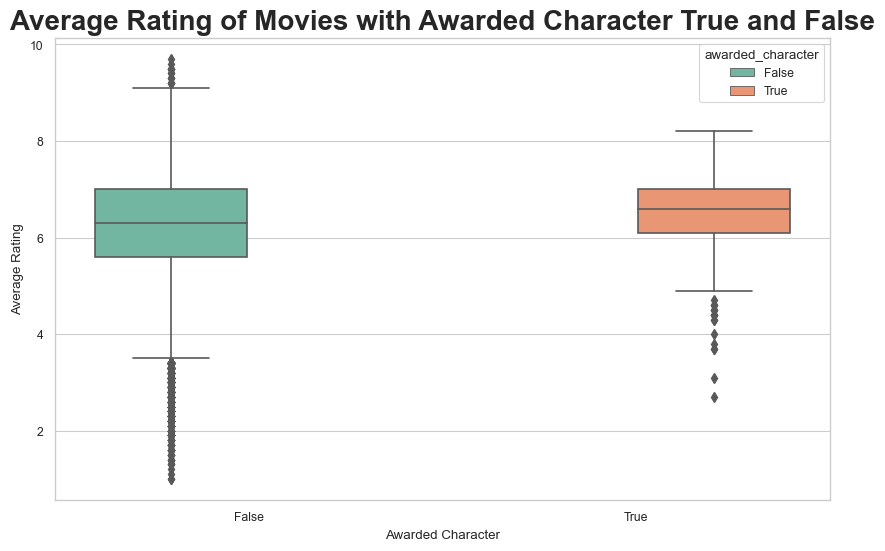

In [83]:
# plot the average rating of the movies with awarded_character true and false
plt.figure(figsize=(10, 6))
sns.boxplot(x='awarded_character', y='averageRating', data=movie_metadata_rating_df, hue='awarded_character')
plt.xlabel('Awarded Character')
plt.ylabel('Average Rating')
plt.title('Average Rating of Movies with Awarded Character True and False')
plt.show()

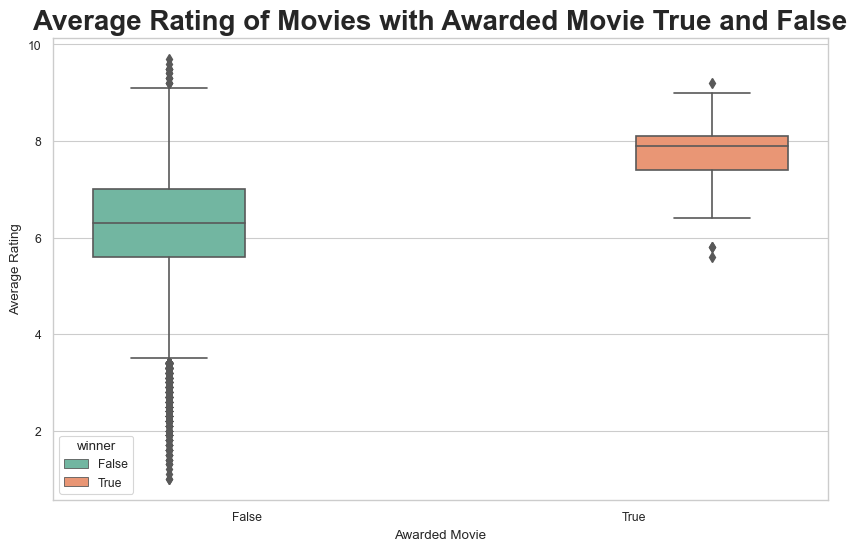

In [84]:
# plot the average rating of the movies with won oscar true and false
plt.figure(figsize=(10, 6))
sns.boxplot(x='winner', y='averageRating', data=movie_metadata_rating_award_df, hue='winner')
plt.xlabel('Awarded Movie')
plt.ylabel('Average Rating')
plt.title('Average Rating of Movies with Awarded Movie True and False')
plt.show()